Leatherback Sea Turtle Dive Profile CNN Development Notebook

Training CNN for Dive Profile Identification

In [1]:
#Libraries
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
import base64
import pandas as pd
import os
import PIL
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
#from pathlib import Path
from numpy import *
import torch
print(torch.cuda.is_available())

True


Setting a path to training images

In [3]:
path = Path("YOUR FILE PATH HERE")
dir_list = [x for x in path.iterdir() if x.is_dir()]
print(dir_list)
path.ls()

[Path('D:/Fast_Pics/Dive_Standard2/models'), Path('D:/Fast_Pics/Dive_Standard2/train')]


(#2) [Path('D:/Fast_Pics/Dive_Standard2/models'),Path('D:/Fast_Pics/Dive_Standard2/train')]

Loading Image Bunch

In [4]:
# Here we set a random seed for subsetting data
# You'll want to keep this number consistent unless you want to change which data are set for training and which are set for testing
np.random.seed(22)

DP = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  splitter=RandomSplitter(0.2),
                  get_y=parent_label,
                  item_tfms= Resize(220,'squish'),
                  batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)])
                 # batch_tfms=aug_transforms(min_scale=0, size=224).append(Normalize.from_stats(*imagenet_stats)

In [5]:
# set the batch size
dls = DP.dataloaders(path, bs = 32)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


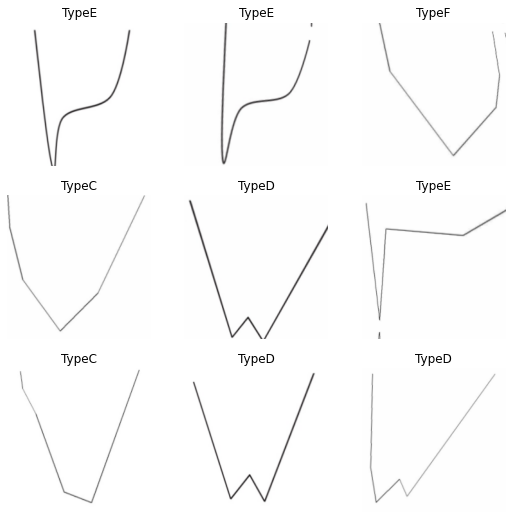

In [6]:
#Visualization of batch data
dls.show_batch(max_n = 9)

In [7]:
#Check the classes (add '.o2i' after vocab to show tensor label numb)
dls.vocab.o2i

{'TypeA': 0, 'TypeC': 1, 'TypeD': 2, 'TypeE': 3, 'TypeF': 4}

Model Training

In [8]:
#Generate the Learner, note the size of the resnet is determined here
learn = cnn_learner(dls, resnet34, pretrained=True, metrics= (error_rate, accuracy)).to_fp16()

In [9]:
#Initial Training Burn-in
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.757822,3.227981,0.891892,0.108108,00:03
1,2.187518,2.364972,0.864865,0.135135,00:00


In [10]:
#Unfreeze the model by running the chunk below, and then continue to train.
learn.unfreeze()
#learn.freeze()
#learn.load('DPA1')
#learn.save('DPStandard_')

In [11]:
# Using learn.fit_one_cycle we can train the model as much as needed in one code chunk.
# Below we have left our training sessions...
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.336243,1.674271,0.756757,0.243243,00:01
1,1.529548,1.445983,0.621622,0.378378,00:00
2,1.435430,2.385124,0.729730,0.270270,00:00
3,1.274977,0.906764,0.351351,0.648649,00:00


In [12]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.745289,0.503518,0.216216,0.783784,00:00
1,0.668233,0.781648,0.243243,0.756757,00:00
2,0.764475,3.113784,0.459459,0.540541,00:00
3,0.837127,2.239521,0.324324,0.675676,00:00
4,0.782285,0.693873,0.162162,0.837838,00:00
5,0.755429,1.380770,0.189189,0.810811,00:00
6,0.736579,0.161519,0.054054,0.945946,00:00
7,0.681940,0.158103,0.081081,0.918919,00:00
8,0.646702,0.181793,0.081081,0.918919,00:00
9,0.607025,0.190261,0.081081,0.918919,00:00


In [19]:
learn.fit_one_cycle(25, lr_max=slice(1e-7, 1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.336786,0.205035,0.081081,0.918919,00:00
1,0.370294,0.198792,0.081081,0.918919,00:00
2,0.345905,0.207416,0.081081,0.918919,00:00
3,0.304249,0.185865,0.054054,0.945946,00:00
4,0.314298,0.188265,0.054054,0.945946,00:00
5,0.294724,0.187362,0.054054,0.945946,00:00
6,0.283177,0.230116,0.081081,0.918919,00:00
7,0.288866,0.322408,0.108108,0.891892,00:00
8,0.304845,0.216391,0.108108,0.891892,00:00
9,0.292041,0.161363,0.054054,0.945946,00:00


In [22]:
#0.325126	0.180906	0.054054	0.945946
learn.fit_one_cycle(13, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.256556,0.206680,0.081081,0.918919,00:00
1,0.350523,0.210679,0.081081,0.918919,00:00
2,0.373132,0.205665,0.081081,0.918919,00:00
3,0.367185,0.204855,0.081081,0.918919,00:00
4,0.358158,0.200875,0.081081,0.918919,00:00
5,0.363977,0.200739,0.081081,0.918919,00:00
6,0.380761,0.188452,0.054054,0.945946,00:00
7,0.378050,0.190693,0.054054,0.945946,00:00
8,0.394468,0.184977,0.054054,0.945946,00:00
9,0.368528,0.189438,0.054054,0.945946,00:00


In [30]:
learn.fit_one_cycle(10, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.330086,0.179890,0.054054,0.945946,00:00
1,0.291692,0.173632,0.054054,0.945946,00:00
2,0.297625,0.175910,0.054054,0.945946,00:00
3,0.301964,0.182334,0.054054,0.945946,00:00
4,0.293743,0.175441,0.054054,0.945946,00:00
5,0.308492,0.165246,0.054054,0.945946,00:00
6,0.321816,0.164613,0.054054,0.945946,00:00
7,0.307337,0.161653,0.054054,0.945946,00:00
8,0.326277,0.161759,0.054054,0.945946,00:00
9,0.324893,0.171826,0.054054,0.945946,00:00


In [41]:
learn.fit_one_cycle(15, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.218517,0.144634,0.054054,0.945946,00:00
1,0.224487,0.146459,0.054054,0.945946,00:00
2,0.220651,0.144122,0.054054,0.945946,00:00
3,0.233879,0.152137,0.054054,0.945946,00:00
4,0.233779,0.155320,0.054054,0.945946,00:00
5,0.260586,0.163717,0.081081,0.918919,00:00
6,0.245806,0.154051,0.054054,0.945946,00:00
7,0.255004,0.158902,0.081081,0.918919,00:00
8,0.258028,0.162829,0.081081,0.918919,00:00
9,0.264968,0.167821,0.081081,0.918919,00:00


In [46]:
learn.fit_one_cycle(15, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.310938,0.165240,0.054054,0.945946,00:01
1,0.314586,0.160907,0.054054,0.945946,00:00
2,0.265714,0.158741,0.054054,0.945946,00:00
3,0.243425,0.143343,0.054054,0.945946,00:00
4,0.215343,0.144163,0.054054,0.945946,00:00
5,0.217639,0.138941,0.054054,0.945946,00:00
6,0.216080,0.144491,0.054054,0.945946,00:00
7,0.231661,0.167637,0.054054,0.945946,00:00
8,0.236229,0.155206,0.054054,0.945946,00:00
9,0.248122,0.154427,0.054054,0.945946,00:00


In [48]:
#This is the final training session.
learn.fit_one_cycle(25, lr_max=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.209447,0.155062,0.054054,0.945946,00:00
1,0.241918,0.148686,0.054054,0.945946,00:00
2,0.229585,0.152723,0.054054,0.945946,00:00
3,0.257743,0.158278,0.054054,0.945946,00:00
4,0.245534,0.163213,0.054054,0.945946,00:00
5,0.232727,0.158814,0.054054,0.945946,00:00
6,0.240522,0.147526,0.054054,0.945946,00:00
7,0.255745,0.134784,0.054054,0.945946,00:00
8,0.253933,0.130218,0.054054,0.945946,00:00
9,0.239236,0.133498,0.054054,0.945946,00:00


In [1]:
# Here you can save the model, the line has been left commented out, be sure to change your file name as needed.
#learn.save('YOUR_FILE_NAME')

In [ ]:
#Here you can load your model, the line has been left commented out 
#learn.load('YOUR_MODEL')

Interpretation

In [50]:
# Here are some yools you can use to interpret how your model is training between training sessions.
# For more on these tools please refer to Jeremy Howards Fast.ai course
# https://docs.fast.ai/interpret.html

interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

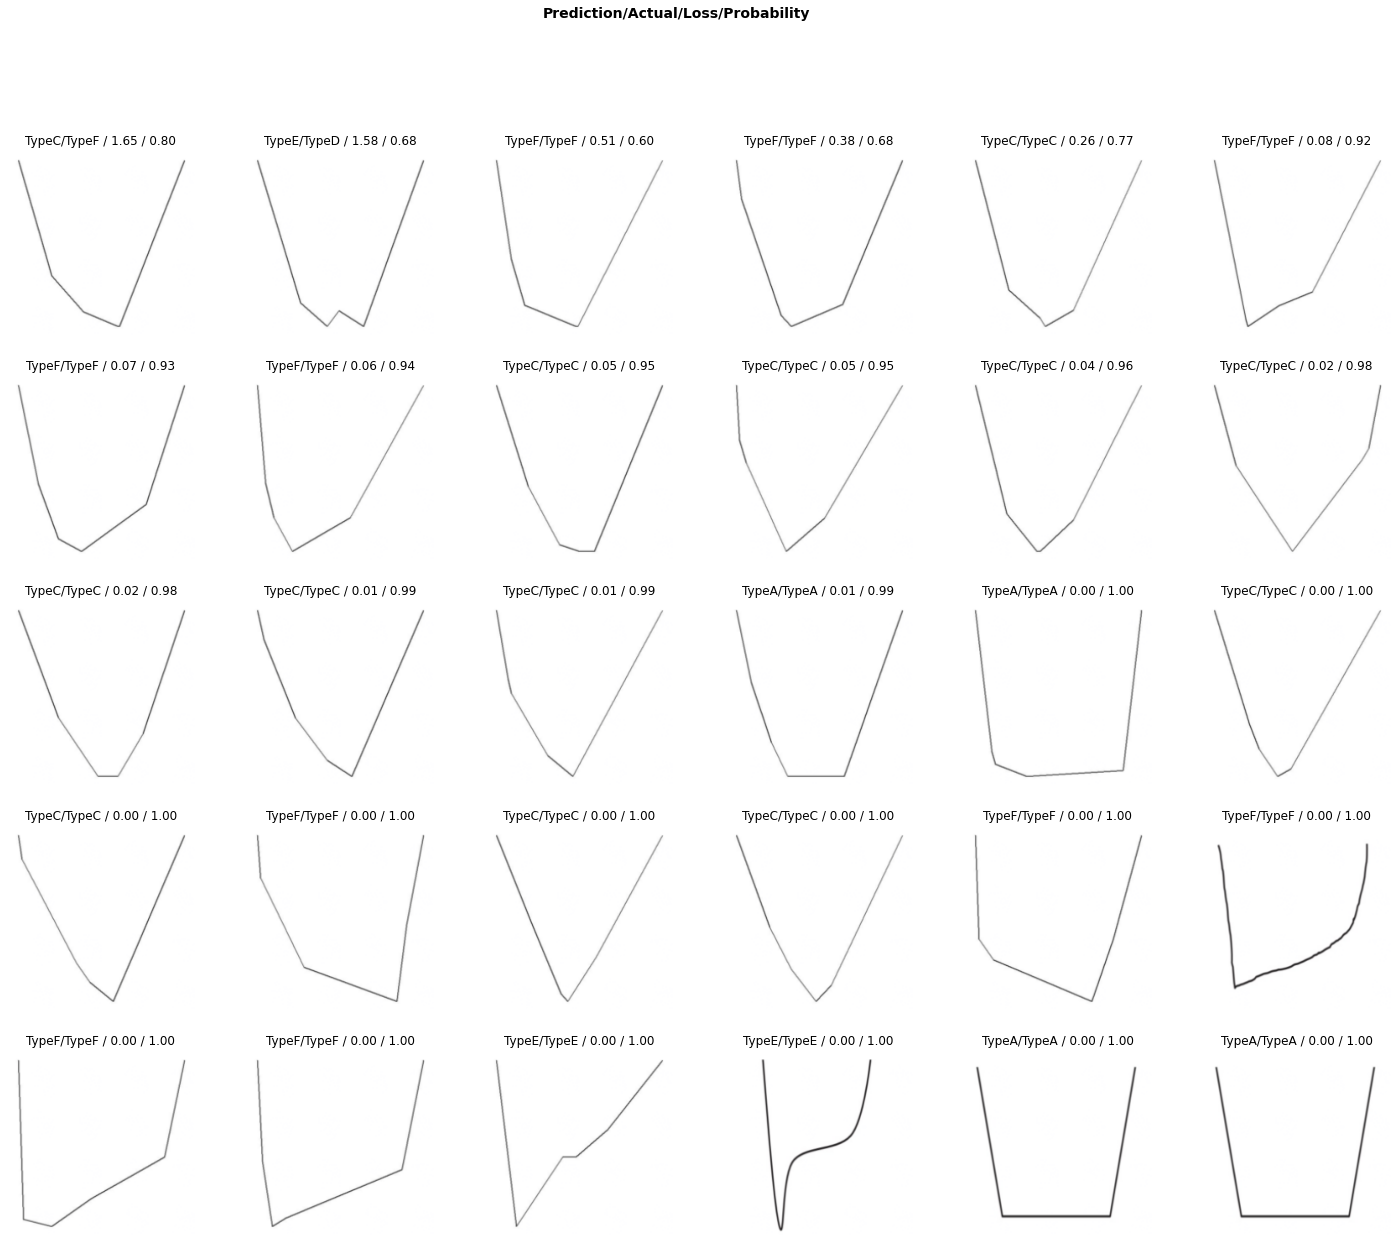

In [53]:
# Plotting the images the model struggled with the most

interp.plot_top_losses(30, figsize=(25,20), largest=True)

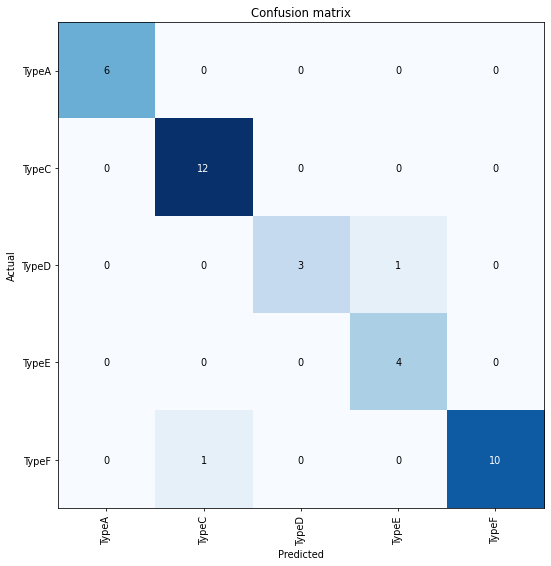

In [52]:
# Printing a Confusion Matrix

interp.plot_confusion_matrix(figsize=(8,8), dpi=70)

SuggestedLRs(lr_min=2.0892961401841602e-06, lr_steep=1.0964781722577754e-06)

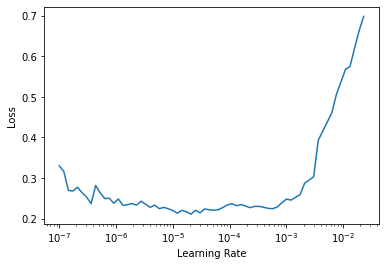

In [55]:
#Use this to find the learning rate between training sessions to fine-tune the model.

learn.lr_find()

Inference

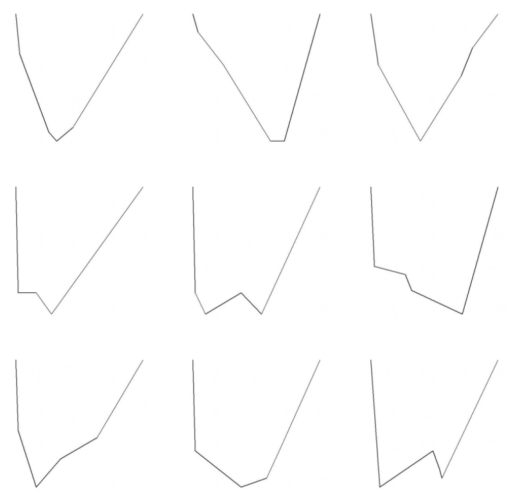

In [56]:
# Here you can use your loaded model to run inference on batches of images

fnames = get_image_files('PATH_TO_YOUR_FILES')
dl = learn.dls.test_dl(fnames[:])
dl.show_batch()

In [57]:
#get preds for batch
pred_tensor, ignored, preds = learn.get_preds(dl=dl, with_decoded=True)

#outputs of above
pred_tensor
#tensor([[0.8150, 0.0348, 0.0220, 0.0258, 0.1023]])

#category index
preds
#tensor([0])

#index into vocab to turn int index into label 
learn.dls.vocab[0] 

learn.dls.vocab.o2i
#output full dictionary of category index and label
#{'label1': 0, 'label2': 1, 'label3': 2, 'invalid': 3, 'negative': 4}

{'TypeA': 0, 'TypeC': 1, 'TypeD': 2, 'TypeE': 3, 'TypeF': 4}

In [58]:
# Run for inference on images

for index,item in enumerate(pred_tensor):
    prediction = learn.dls.categorize.decode(np.argmax(item)).upper()
    confidence = max(item)
    percent = float(confidence)
    label_name = (str(fnames[index]).split("\\")[-1])
    print(f"{prediction},{percent*100:.2f}%,{label_name}")
    #learn.dl.show_batch()

TYPEC,98.65%,1.jpg
TYPEC,99.22%,10.jpg
TYPEC,99.60%,100.jpg
TYPEE,100.00%,1000.jpg
TYPEE,96.74%,10000.jpg
TYPEF,68.40%,10001.jpg
TYPEE,90.57%,10002.jpg
TYPEF,96.60%,10003.jpg
TYPEE,65.03%,10004.jpg
TYPEF,90.13%,10005.jpg
TYPEF,69.50%,10006.jpg
TYPEF,63.56%,10007.jpg
TYPED,99.98%,10008.jpg
TYPEE,91.80%,10009.jpg
TYPED,100.00%,1001.jpg
TYPEF,94.69%,10010.jpg
TYPEF,98.79%,10011.jpg
TYPEE,98.54%,10012.jpg
TYPEC,62.71%,10013.jpg
TYPEC,99.62%,10014.jpg
TYPEE,83.86%,10015.jpg
TYPEC,48.56%,10016.jpg
TYPEC,99.62%,10017.jpg
TYPEC,99.04%,10018.jpg
TYPEC,99.72%,10019.jpg
TYPEE,99.88%,1002.jpg
TYPEC,94.64%,10020.jpg
TYPEC,99.76%,10021.jpg
TYPEC,97.75%,10022.jpg
TYPEC,95.59%,10023.jpg
TYPEA,55.77%,10024.jpg
TYPEF,63.72%,10025.jpg
TYPEF,65.18%,10026.jpg
TYPEC,58.89%,10027.jpg
TYPEA,83.57%,10028.jpg
TYPEF,96.33%,10029.jpg
TYPEC,80.66%,1003.jpg
TYPEA,99.98%,10030.jpg
TYPEF,96.43%,10031.jpg
TYPEE,99.99%,10032.jpg
TYPEE,97.91%,10033.jpg
TYPEE,97.51%,10034.jpg
TYPEE,91.94%,10035.jpg
TYPEC,98.01%,10036.jpg

TYPEF,79.19%,10565.jpg
TYPEE,100.00%,10566.jpg
TYPEC,98.34%,10567.jpg
TYPED,100.00%,10568.jpg
TYPEF,56.41%,10569.jpg
TYPED,100.00%,1057.jpg
TYPEC,67.18%,10570.jpg
TYPED,99.84%,10571.jpg
TYPEF,95.55%,10572.jpg
TYPEC,87.80%,10573.jpg
TYPEF,52.75%,10574.jpg
TYPEE,97.41%,10575.jpg
TYPEC,96.01%,10576.jpg
TYPEF,97.13%,10577.jpg
TYPEF,92.80%,10578.jpg
TYPED,63.95%,10579.jpg
TYPEE,99.84%,1058.jpg
TYPEC,93.32%,10580.jpg
TYPEA,98.95%,10581.jpg
TYPEF,96.46%,10582.jpg
TYPEF,99.82%,10583.jpg
TYPEF,85.51%,10584.jpg
TYPEE,88.32%,10585.jpg
TYPEF,95.14%,10586.jpg
TYPEF,95.56%,10587.jpg
TYPEC,95.44%,10588.jpg
TYPEC,99.75%,10589.jpg
TYPEC,99.39%,1059.jpg
TYPEE,99.96%,10590.jpg
TYPEE,99.97%,10591.jpg
TYPEE,90.51%,10592.jpg
TYPEC,98.32%,10593.jpg
TYPEC,96.25%,10594.jpg
TYPED,100.00%,10595.jpg
TYPEE,100.00%,10596.jpg
TYPEA,73.98%,10597.jpg
TYPEC,68.42%,10598.jpg
TYPEE,61.78%,10599.jpg
TYPEC,91.93%,106.jpg
TYPEE,99.84%,1060.jpg
TYPEF,59.40%,10600.jpg
TYPEC,88.71%,10601.jpg
TYPEC,85.02%,10602.jpg
TYPEC,98.08%

TYPEE,88.90%,11144.jpg
TYPEF,78.99%,11145.jpg
TYPEC,54.74%,11146.jpg
TYPEC,99.37%,11147.jpg
TYPEF,89.33%,11148.jpg
TYPEE,45.56%,11149.jpg
TYPEE,99.92%,1115.jpg
TYPEC,99.49%,11150.jpg
TYPEC,81.62%,11151.jpg
TYPEC,96.29%,11152.jpg
TYPED,99.99%,11153.jpg
TYPED,100.00%,11154.jpg
TYPED,68.69%,11155.jpg
TYPEF,98.57%,11156.jpg
TYPEF,94.45%,11157.jpg
TYPEC,44.90%,11158.jpg
TYPEE,99.77%,11159.jpg
TYPEF,68.95%,1116.jpg
TYPEE,70.07%,11160.jpg
TYPED,62.80%,11161.jpg
TYPEC,68.45%,11162.jpg
TYPEE,100.00%,11163.jpg
TYPEC,99.82%,11164.jpg
TYPEA,98.51%,11165.jpg
TYPED,95.87%,11166.jpg
TYPEC,94.74%,11167.jpg
TYPEF,63.16%,11168.jpg
TYPEF,53.46%,11169.jpg
TYPED,100.00%,1117.jpg
TYPEE,99.97%,11170.jpg
TYPEF,50.84%,11171.jpg
TYPEC,98.37%,11172.jpg
TYPEC,71.37%,11173.jpg
TYPEC,98.73%,11174.jpg
TYPEC,65.16%,11175.jpg
TYPEC,98.79%,11176.jpg
TYPEC,96.07%,11177.jpg
TYPEA,68.09%,11178.jpg
TYPEC,99.23%,11179.jpg
TYPEE,99.98%,1118.jpg
TYPEE,99.59%,11180.jpg
TYPEE,99.65%,11181.jpg
TYPEC,99.72%,11182.jpg
TYPEE,92.33%

TYPEC,68.86%,11725.jpg
TYPEC,90.85%,11726.jpg
TYPEC,95.13%,11727.jpg
TYPEC,94.73%,11728.jpg
TYPEC,99.94%,11729.jpg
TYPEC,88.56%,1173.jpg
TYPEC,90.99%,11730.jpg
TYPEC,99.10%,11731.jpg
TYPEC,99.14%,11732.jpg
TYPEC,65.12%,11733.jpg
TYPEC,98.49%,11734.jpg
TYPEF,56.52%,11735.jpg
TYPEE,98.63%,11736.jpg
TYPEF,99.32%,11737.jpg
TYPEA,57.33%,11738.jpg
TYPEF,98.20%,11739.jpg
TYPEE,97.30%,1174.jpg
TYPEF,82.17%,11740.jpg
TYPEC,99.81%,11741.jpg
TYPEC,94.69%,11742.jpg
TYPEC,99.86%,11743.jpg
TYPEC,98.74%,11744.jpg
TYPEC,95.81%,11745.jpg
TYPEC,94.85%,11746.jpg
TYPEE,98.14%,11747.jpg
TYPEA,81.79%,11748.jpg
TYPEE,99.95%,11749.jpg
TYPEC,99.44%,1175.jpg
TYPEF,34.41%,11750.jpg
TYPEE,99.94%,11751.jpg
TYPED,100.00%,11752.jpg
TYPEA,65.56%,11753.jpg
TYPEC,98.18%,11754.jpg
TYPEF,76.95%,11755.jpg
TYPEE,100.00%,11756.jpg
TYPEE,99.76%,11757.jpg
TYPEC,94.42%,11758.jpg
TYPEC,99.89%,11759.jpg
TYPEE,99.80%,1176.jpg
TYPEC,99.64%,11760.jpg
TYPEC,93.54%,11761.jpg
TYPEF,92.25%,11762.jpg
TYPEC,99.67%,11763.jpg
TYPEE,86.76%,

TYPEA,51.79%,12306.jpg
TYPEF,91.41%,12307.jpg
TYPEA,84.11%,12308.jpg
TYPEA,53.47%,12309.jpg
TYPEC,99.50%,1231.jpg
TYPEA,99.74%,12310.jpg
TYPEF,93.38%,12311.jpg
TYPEF,80.85%,12312.jpg
TYPEF,90.33%,12313.jpg
TYPEE,59.46%,12314.jpg
TYPEF,52.71%,12315.jpg
TYPEF,98.38%,12316.jpg
TYPEF,97.17%,12317.jpg
TYPEC,99.64%,12318.jpg
TYPEE,99.98%,12319.jpg
TYPEF,92.50%,1232.jpg
TYPEE,99.99%,12320.jpg
TYPEF,91.77%,12321.jpg
TYPED,51.25%,12322.jpg
TYPEF,94.04%,12323.jpg
TYPED,100.00%,12324.jpg
TYPEA,76.43%,12325.jpg
TYPEE,80.23%,12326.jpg
TYPEE,98.54%,12327.jpg
TYPEE,62.41%,12328.jpg
TYPEF,50.18%,12329.jpg
TYPEF,93.00%,1233.jpg
TYPEC,99.83%,12330.jpg
TYPEF,92.39%,12331.jpg
TYPEE,99.64%,12332.jpg
TYPEC,73.45%,12333.jpg
TYPEC,90.12%,12334.jpg
TYPEE,99.99%,12335.jpg
TYPEE,100.00%,12336.jpg
TYPEC,63.99%,12337.jpg
TYPEC,97.09%,12338.jpg
TYPEE,99.97%,12339.jpg
TYPEE,100.00%,1234.jpg
TYPED,100.00%,12340.jpg
TYPEE,83.84%,12341.jpg
TYPEF,60.75%,12342.jpg
TYPEA,99.53%,12343.jpg
TYPEF,50.45%,12344.jpg
TYPEF,55.27

TYPEF,49.49%,12890.jpg
TYPEC,96.44%,12891.jpg
TYPEC,98.98%,12892.jpg
TYPEF,99.99%,12893.jpg
TYPEC,96.78%,12894.jpg
TYPEF,83.21%,12895.jpg
TYPED,100.00%,12896.jpg
TYPEF,99.02%,12897.jpg
TYPEE,100.00%,12898.jpg
TYPEC,92.67%,12899.jpg
TYPEF,42.53%,129.jpg
TYPEC,99.47%,1290.jpg
TYPEE,98.92%,12900.jpg
TYPEE,100.00%,12901.jpg
TYPED,100.00%,12902.jpg
TYPEC,75.19%,12903.jpg
TYPEF,98.56%,12904.jpg
TYPED,100.00%,12905.jpg
TYPEC,68.88%,12906.jpg
TYPEC,99.79%,12907.jpg
TYPEE,99.99%,12908.jpg
TYPEC,90.30%,12909.jpg
TYPEF,99.89%,1291.jpg
TYPED,100.00%,12910.jpg
TYPEC,64.98%,12911.jpg
TYPEC,95.21%,12912.jpg
TYPED,100.00%,12913.jpg
TYPEF,99.54%,12914.jpg
TYPEC,74.97%,12915.jpg
TYPEC,99.54%,12916.jpg
TYPEE,99.93%,12917.jpg
TYPEA,99.68%,12918.jpg
TYPEA,95.23%,12919.jpg
TYPEE,98.63%,1292.jpg
TYPED,100.00%,12920.jpg
TYPED,100.00%,12921.jpg
TYPEC,65.79%,12922.jpg
TYPEE,97.86%,12923.jpg
TYPEE,99.98%,12924.jpg
TYPEE,99.97%,12925.jpg
TYPEA,83.71%,12926.jpg
TYPEC,91.83%,12927.jpg
TYPEE,97.78%,12928.jpg
TYPEE,1

TYPEC,83.41%,13474.jpg
TYPEC,53.29%,13475.jpg
TYPEA,80.39%,13476.jpg
TYPED,100.00%,13477.jpg
TYPEC,97.22%,13478.jpg
TYPEE,99.87%,13479.jpg
TYPEF,97.79%,1348.jpg
TYPEE,94.77%,13480.jpg
TYPEC,93.68%,13481.jpg
TYPEC,99.01%,13482.jpg
TYPEC,98.81%,13483.jpg
TYPEC,66.54%,13484.jpg
TYPEE,77.21%,13485.jpg
TYPEC,99.49%,13486.jpg
TYPEC,99.84%,13487.jpg
TYPEE,98.33%,13488.jpg
TYPEE,100.00%,13489.jpg
TYPED,100.00%,1349.jpg
TYPEC,99.84%,13490.jpg
TYPEC,97.77%,13491.jpg
TYPEE,100.00%,13492.jpg
TYPEC,53.50%,13493.jpg
TYPEF,86.98%,13494.jpg
TYPEC,99.41%,13495.jpg
TYPEC,99.23%,13496.jpg
TYPEC,99.85%,13497.jpg
TYPEC,99.73%,13498.jpg
TYPEE,78.37%,13499.jpg
TYPEF,80.36%,135.jpg
TYPEA,81.82%,1350.jpg
TYPEC,99.60%,13500.jpg
TYPEE,99.23%,13501.jpg
TYPEC,95.52%,13502.jpg
TYPEE,95.80%,13503.jpg
TYPEC,96.59%,13504.jpg
TYPEE,81.78%,13505.jpg
TYPEE,100.00%,13507.jpg
TYPEC,99.71%,13508.jpg
TYPED,87.99%,13509.jpg
TYPED,72.50%,1351.jpg
TYPEC,99.82%,13510.jpg
TYPEE,87.70%,13511.jpg
TYPEC,99.78%,13512.jpg
TYPEC,99.24%

TYPEC,99.42%,14053.jpg
TYPEE,100.00%,14054.jpg
TYPEC,98.51%,14055.jpg
TYPEE,99.99%,14056.jpg
TYPEF,99.28%,14057.jpg
TYPEC,74.11%,14058.jpg
TYPEF,99.50%,14059.jpg
TYPEC,96.38%,1406.jpg
TYPEF,94.90%,14060.jpg
TYPEF,87.38%,14061.jpg
TYPEF,93.94%,14062.jpg
TYPEC,91.90%,14063.jpg
TYPEE,53.73%,14064.jpg
TYPEE,99.98%,14065.jpg
TYPED,99.97%,14066.jpg
TYPEC,87.51%,14067.jpg
TYPEE,58.22%,14068.jpg
TYPEF,97.67%,14069.jpg
TYPED,100.00%,1407.jpg
TYPEF,80.97%,14070.jpg
TYPEC,63.01%,14071.jpg
TYPEE,99.78%,14072.jpg
TYPEF,68.29%,14073.jpg
TYPED,99.98%,14074.jpg
TYPEC,98.21%,14075.jpg
TYPED,100.00%,14076.jpg
TYPED,84.67%,14077.jpg
TYPED,74.68%,14078.jpg
TYPEA,99.40%,14079.jpg
TYPEC,98.81%,1408.jpg
TYPEC,96.50%,14080.jpg
TYPED,96.05%,14081.jpg
TYPEC,99.05%,14082.jpg
TYPEC,99.78%,14083.jpg
TYPEE,97.26%,14084.jpg
TYPEC,96.33%,14085.jpg
TYPEC,95.28%,14086.jpg
TYPEE,99.96%,14087.jpg
TYPEC,99.27%,14088.jpg
TYPEC,99.00%,14089.jpg
TYPEC,96.90%,1409.jpg
TYPEC,96.78%,14090.jpg
TYPEE,97.27%,14091.jpg
TYPED,97.72%

TYPEF,43.60%,14592.jpg
TYPEF,81.87%,14593.jpg
TYPEE,98.84%,14594.jpg
TYPEC,77.95%,14595.jpg
TYPEF,95.01%,14596.jpg
TYPEF,70.51%,14597.jpg
TYPEF,54.84%,14598.jpg
TYPEA,57.83%,14599.jpg
TYPEF,85.46%,146.jpg
TYPEC,99.65%,1460.jpg
TYPEC,52.45%,14600.jpg
TYPEA,97.45%,14601.jpg
TYPEA,88.47%,14602.jpg
TYPEF,79.16%,14603.jpg
TYPEC,95.15%,14604.jpg
TYPEC,60.89%,14605.jpg
TYPEC,99.18%,14606.jpg
TYPEC,56.63%,14607.jpg
TYPEF,61.78%,14608.jpg
TYPEC,93.30%,14609.jpg
TYPEE,99.47%,1461.jpg
TYPEC,96.96%,14610.jpg
TYPEC,98.50%,14611.jpg
TYPEE,99.83%,14612.jpg
TYPEF,94.61%,14613.jpg
TYPEC,80.65%,14614.jpg
TYPEC,40.31%,14615.jpg
TYPEC,98.45%,14616.jpg
TYPEC,93.80%,14617.jpg
TYPEC,98.20%,14618.jpg
TYPEC,97.76%,14619.jpg
TYPEC,99.91%,1462.jpg
TYPEC,96.02%,14620.jpg
TYPEF,94.43%,14621.jpg
TYPEC,91.29%,14622.jpg
TYPEF,99.55%,14623.jpg
TYPEC,52.71%,14624.jpg
TYPEC,72.22%,14625.jpg
TYPEC,99.22%,14626.jpg
TYPEF,94.38%,14627.jpg
TYPEE,99.75%,14628.jpg
TYPEE,99.98%,14629.jpg
TYPEE,96.79%,1463.jpg
TYPEA,97.20%,1463

TYPEE,99.76%,15164.jpg
TYPEF,66.12%,15165.jpg
TYPEE,65.85%,15166.jpg
TYPEC,63.32%,15167.jpg
TYPEF,99.89%,15168.jpg
TYPED,99.99%,15169.jpg
TYPEC,84.95%,1517.jpg
TYPEF,78.45%,15170.jpg
TYPEC,96.36%,15171.jpg
TYPEC,54.38%,15172.jpg
TYPEE,99.05%,15173.jpg
TYPEA,99.69%,15174.jpg
TYPEC,82.16%,15175.jpg
TYPEE,99.87%,15176.jpg
TYPEE,100.00%,15177.jpg
TYPEF,96.30%,15178.jpg
TYPEE,99.92%,15179.jpg
TYPEC,96.71%,1518.jpg
TYPEF,63.70%,15180.jpg
TYPEE,99.52%,15181.jpg
TYPEE,98.34%,15182.jpg
TYPED,99.97%,15183.jpg
TYPEE,96.80%,15184.jpg
TYPEE,99.91%,15185.jpg
TYPEE,99.77%,15186.jpg
TYPEC,95.11%,15187.jpg
TYPEC,52.41%,15188.jpg
TYPEE,100.00%,15189.jpg
TYPED,99.29%,1519.jpg
TYPEE,95.73%,15190.jpg
TYPEE,100.00%,15191.jpg
TYPEE,100.00%,15192.jpg
TYPEE,76.38%,15193.jpg
TYPEE,99.96%,15194.jpg
TYPEE,72.91%,15195.jpg
TYPEE,99.91%,15196.jpg
TYPED,99.07%,15197.jpg
TYPEF,57.06%,15198.jpg
TYPEC,93.53%,15199.jpg
TYPEC,88.77%,152.jpg
TYPEE,99.27%,1520.jpg
TYPEE,99.97%,15200.jpg
TYPEF,91.11%,15201.jpg
TYPEF,43.57%,

TYPEE,98.91%,15736.jpg
TYPEE,99.99%,15737.jpg
TYPEE,99.12%,15738.jpg
TYPEA,99.93%,15739.jpg
TYPEE,99.91%,1574.jpg
TYPEA,98.95%,15740.jpg
TYPEA,44.52%,15741.jpg
TYPEC,95.99%,15742.jpg
TYPEF,98.47%,15743.jpg
TYPEE,92.58%,15744.jpg
TYPEA,58.03%,15745.jpg
TYPEF,74.89%,15746.jpg
TYPEC,42.24%,15747.jpg
TYPED,99.70%,15748.jpg
TYPEE,54.50%,15749.jpg
TYPEC,98.28%,1575.jpg
TYPED,97.24%,15750.jpg
TYPED,100.00%,15751.jpg
TYPEF,73.12%,15752.jpg
TYPEC,96.43%,15753.jpg
TYPEC,73.42%,15754.jpg
TYPEE,78.01%,15755.jpg
TYPEC,93.11%,15756.jpg
TYPEE,99.77%,15757.jpg
TYPEC,95.97%,15758.jpg
TYPED,99.98%,15759.jpg
TYPEC,88.09%,1576.jpg
TYPED,99.98%,15760.jpg
TYPED,79.01%,15761.jpg
TYPEC,99.36%,15762.jpg
TYPEC,94.12%,15763.jpg
TYPEE,84.12%,15764.jpg
TYPEE,100.00%,15765.jpg
TYPED,99.99%,15766.jpg
TYPEC,99.80%,15767.jpg
TYPEC,80.45%,15768.jpg
TYPEC,89.70%,15769.jpg
TYPEC,79.16%,1577.jpg
TYPEC,95.48%,15770.jpg
TYPEC,89.10%,15771.jpg
TYPEC,66.03%,15772.jpg
TYPEE,99.96%,15773.jpg
TYPEC,98.20%,15774.jpg
TYPEE,99.36%,

TYPEC,77.21%,16275.jpg
TYPEC,67.04%,16276.jpg
TYPEE,99.47%,16277.jpg
TYPEA,77.57%,16278.jpg
TYPEC,71.72%,16279.jpg
TYPEF,61.71%,1628.jpg
TYPEF,80.81%,16280.jpg
TYPEF,84.78%,16281.jpg
TYPEC,99.33%,16282.jpg
TYPEC,78.26%,16283.jpg
TYPEF,88.95%,16284.jpg
TYPEC,99.00%,16285.jpg
TYPEF,94.28%,16286.jpg
TYPEF,50.29%,16287.jpg
TYPEC,99.82%,16288.jpg
TYPEC,93.79%,16289.jpg
TYPEC,78.42%,1629.jpg
TYPEF,99.86%,16290.jpg
TYPEC,53.72%,16291.jpg
TYPEC,99.34%,16292.jpg
TYPEA,99.33%,16293.jpg
TYPEC,99.39%,16294.jpg
TYPEC,99.81%,16295.jpg
TYPEA,99.17%,16296.jpg
TYPEA,59.19%,16297.jpg
TYPEC,71.52%,16298.jpg
TYPEC,99.84%,16299.jpg
TYPEF,85.45%,163.jpg
TYPEC,99.47%,1630.jpg
TYPEF,57.92%,16300.jpg
TYPEE,99.98%,16301.jpg
TYPEC,99.07%,16302.jpg
TYPEE,99.98%,16303.jpg
TYPEC,98.82%,16304.jpg
TYPEC,99.28%,16305.jpg
TYPEC,88.45%,16306.jpg
TYPEC,92.54%,16307.jpg
TYPEF,99.10%,16308.jpg
TYPEF,47.25%,16309.jpg
TYPEE,100.00%,1631.jpg
TYPEF,75.46%,16310.jpg
TYPEF,67.60%,16311.jpg
TYPEC,81.52%,16312.jpg
TYPEF,90.04%,163

TYPEE,93.82%,16846.jpg
TYPEF,99.64%,16847.jpg
TYPEE,100.00%,16848.jpg
TYPEA,89.25%,16849.jpg
TYPEF,99.00%,1685.jpg
TYPEC,90.14%,16850.jpg
TYPEE,99.95%,16851.jpg
TYPEF,74.24%,16852.jpg
TYPEE,99.52%,16853.jpg
TYPEC,91.73%,16854.jpg
TYPEA,83.71%,16855.jpg
TYPEF,97.56%,16856.jpg
TYPEE,99.38%,16857.jpg
TYPEE,97.86%,16858.jpg
TYPEE,100.00%,16859.jpg
TYPEC,99.13%,1686.jpg
TYPEC,52.78%,16860.jpg
TYPEA,97.66%,16861.jpg
TYPEC,99.89%,16862.jpg
TYPEC,87.58%,16863.jpg
TYPEE,95.41%,16864.jpg
TYPEE,99.97%,16865.jpg
TYPEC,53.79%,16866.jpg
TYPEE,82.18%,16867.jpg
TYPED,100.00%,16868.jpg
TYPEF,97.78%,16869.jpg
TYPEE,99.99%,1687.jpg
TYPEE,99.76%,16870.jpg
TYPEE,99.98%,16871.jpg
TYPEA,75.95%,16872.jpg
TYPEF,85.12%,16873.jpg
TYPEF,99.85%,16874.jpg
TYPEC,67.56%,16875.jpg
TYPEF,99.25%,16876.jpg
TYPEE,97.79%,16877.jpg
TYPED,99.77%,16878.jpg
TYPEC,99.44%,16879.jpg
TYPEE,99.90%,1688.jpg
TYPEA,96.39%,16880.jpg
TYPEC,95.70%,16881.jpg
TYPED,100.00%,16882.jpg
TYPEE,51.71%,16883.jpg
TYPEC,93.14%,16884.jpg
TYPEE,75.84

TYPEA,79.44%,17432.jpg
TYPEA,97.63%,17433.jpg
TYPEE,100.00%,17434.jpg
TYPEA,54.66%,17435.jpg
TYPEF,59.27%,17436.jpg
TYPEF,99.80%,17437.jpg
TYPED,100.00%,17438.jpg
TYPEC,99.71%,17439.jpg
TYPEA,99.30%,1744.jpg
TYPEC,89.25%,17440.jpg
TYPEF,50.65%,17441.jpg
TYPEE,100.00%,17442.jpg
TYPEC,99.85%,17443.jpg
TYPEE,99.98%,17444.jpg
TYPEE,100.00%,17445.jpg
TYPEC,99.61%,17446.jpg
TYPEE,99.99%,17447.jpg
TYPEE,99.99%,17448.jpg
TYPEC,99.37%,17449.jpg
TYPEA,99.41%,1745.jpg
TYPEC,93.13%,17450.jpg
TYPEC,59.89%,17451.jpg
TYPEC,99.32%,17452.jpg
TYPEC,97.46%,17453.jpg
TYPEC,91.91%,17454.jpg
TYPEE,58.91%,17455.jpg
TYPEC,93.44%,17456.jpg
TYPEC,99.49%,17457.jpg
TYPEE,100.00%,17458.jpg
TYPED,100.00%,17459.jpg
TYPEC,92.10%,1746.jpg
TYPEC,76.00%,17460.jpg
TYPEF,97.26%,17461.jpg
TYPEC,99.87%,17462.jpg
TYPEF,73.92%,17463.jpg
TYPEE,100.00%,17464.jpg
TYPEE,94.36%,17465.jpg
TYPEC,98.78%,17466.jpg
TYPEC,92.46%,17467.jpg
TYPEC,91.71%,17468.jpg
TYPEC,97.48%,17469.jpg
TYPEE,99.60%,1747.jpg
TYPEC,90.31%,17470.jpg
TYPED,94

TYPEC,97.31%,17974.jpg
TYPEC,98.52%,17975.jpg
TYPEC,93.56%,17976.jpg
TYPEC,99.82%,17977.jpg
TYPEC,97.06%,17978.jpg
TYPEA,69.87%,17979.jpg
TYPEF,97.69%,1798.jpg
TYPED,78.33%,17980.jpg
TYPEC,99.34%,17981.jpg
TYPEC,99.81%,17982.jpg
TYPEC,99.31%,17983.jpg
TYPEE,100.00%,17984.jpg
TYPEC,99.83%,17985.jpg
TYPEE,49.44%,17986.jpg
TYPEE,99.95%,17987.jpg
TYPEC,99.64%,17988.jpg
TYPEF,91.78%,17989.jpg
TYPEC,41.91%,1799.jpg
TYPED,98.43%,17990.jpg
TYPED,98.59%,17991.jpg
TYPEF,72.59%,17992.jpg
TYPEE,98.17%,17993.jpg
TYPEC,98.32%,17994.jpg
TYPEC,98.75%,17995.jpg
TYPEC,99.70%,17996.jpg
TYPEC,99.76%,17997.jpg
TYPEC,90.52%,17998.jpg
TYPEC,97.83%,17999.jpg
TYPEA,99.58%,18.jpg
TYPEE,96.31%,180.jpg
TYPEC,94.18%,1800.jpg
TYPEA,34.74%,18000.jpg
TYPEE,97.66%,18001.jpg
TYPEC,99.87%,18002.jpg
TYPEE,46.30%,18003.jpg
TYPEC,99.72%,18004.jpg
TYPEE,99.81%,18005.jpg
TYPEC,99.89%,18006.jpg
TYPED,99.79%,18007.jpg
TYPED,99.99%,18008.jpg
TYPEE,99.99%,18009.jpg
TYPEC,92.45%,1801.jpg
TYPEF,72.89%,18010.jpg
TYPEE,99.70%,18011.

TYPED,100.00%,1854.jpg
TYPEF,79.83%,18540.jpg
TYPEC,96.48%,18541.jpg
TYPEE,99.97%,18542.jpg
TYPEC,47.50%,18543.jpg
TYPEF,50.54%,18544.jpg
TYPEE,100.00%,18545.jpg
TYPEC,96.87%,18546.jpg
TYPEC,85.91%,18547.jpg
TYPEA,57.96%,18548.jpg
TYPEE,99.99%,18549.jpg
TYPED,99.99%,1855.jpg
TYPEC,89.18%,18550.jpg
TYPEA,99.99%,18551.jpg
TYPEF,95.06%,18552.jpg
TYPEF,39.12%,18553.jpg
TYPEE,100.00%,18554.jpg
TYPEE,99.92%,18555.jpg
TYPED,99.99%,18556.jpg
TYPEC,90.02%,18557.jpg
TYPEF,97.93%,18558.jpg
TYPEC,64.41%,18559.jpg
TYPEC,99.33%,1856.jpg
TYPEE,100.00%,18560.jpg
TYPEC,85.99%,18561.jpg
TYPEA,73.16%,18562.jpg
TYPEE,99.99%,18563.jpg
TYPEC,99.65%,18564.jpg
TYPED,99.96%,18565.jpg
TYPEC,99.48%,18566.jpg
TYPEC,99.78%,18567.jpg
TYPEE,60.71%,18568.jpg
TYPEC,58.15%,18569.jpg
TYPEE,100.00%,1857.jpg
TYPEC,99.54%,18570.jpg
TYPEF,93.69%,18571.jpg
TYPEE,98.92%,18572.jpg
TYPEC,99.65%,18573.jpg
TYPEC,98.56%,18574.jpg
TYPEE,99.86%,18575.jpg
TYPEA,99.97%,18576.jpg
TYPEF,99.51%,18577.jpg
TYPEC,58.74%,18578.jpg
TYPEE,56.1

TYPEE,99.95%,19068.jpg
TYPEC,91.11%,19069.jpg
TYPEF,81.92%,1907.jpg
TYPEC,95.03%,19070.jpg
TYPED,100.00%,19071.jpg
TYPEC,96.92%,19072.jpg
TYPEC,99.81%,19073.jpg
TYPEC,99.91%,19074.jpg
TYPEE,99.98%,19075.jpg
TYPEC,99.86%,19076.jpg
TYPEE,98.77%,19077.jpg
TYPEE,100.00%,19078.jpg
TYPEF,49.94%,19079.jpg
TYPED,96.80%,1908.jpg
TYPEC,98.89%,19080.jpg
TYPEE,93.77%,19081.jpg
TYPEC,99.91%,19082.jpg
TYPED,100.00%,19083.jpg
TYPEE,51.48%,19084.jpg
TYPEC,98.11%,19085.jpg
TYPEE,99.98%,19086.jpg
TYPEC,99.59%,19087.jpg
TYPEA,47.73%,19088.jpg
TYPED,99.99%,19089.jpg
TYPEC,87.53%,1909.jpg
TYPED,99.61%,19090.jpg
TYPEE,66.18%,19091.jpg
TYPEC,99.73%,19092.jpg
TYPEE,69.76%,19093.jpg
TYPEC,97.11%,19094.jpg
TYPEA,84.74%,19095.jpg
TYPEE,64.99%,19096.jpg
TYPEC,94.93%,19097.jpg
TYPEE,100.00%,19098.jpg
TYPEC,95.67%,19099.jpg
TYPEC,97.75%,191.jpg
TYPEE,56.85%,1910.jpg
TYPEC,82.41%,19100.jpg
TYPEE,94.51%,19101.jpg
TYPEE,99.63%,19102.jpg
TYPED,99.98%,19103.jpg
TYPEC,98.34%,19104.jpg
TYPEC,97.05%,19105.jpg
TYPEC,99.40%,

TYPEE,98.94%,1961.jpg
TYPEE,99.96%,19610.jpg
TYPEC,99.41%,19611.jpg
TYPEC,99.73%,19612.jpg
TYPEC,99.78%,19613.jpg
TYPED,64.69%,19614.jpg
TYPEC,99.05%,19615.jpg
TYPEC,98.24%,19616.jpg
TYPEC,96.26%,19617.jpg
TYPEC,98.21%,19618.jpg
TYPEC,88.76%,19619.jpg
TYPEA,77.55%,1962.jpg
TYPEC,50.32%,19620.jpg
TYPEC,98.33%,19621.jpg
TYPEF,49.11%,19622.jpg
TYPEF,51.72%,19623.jpg
TYPEF,53.16%,19624.jpg
TYPEC,98.74%,19625.jpg
TYPEC,97.17%,19626.jpg
TYPEF,96.69%,19627.jpg
TYPEC,98.77%,19628.jpg
TYPEC,97.99%,19629.jpg
TYPEC,99.34%,1963.jpg
TYPEC,98.38%,19630.jpg
TYPEE,82.72%,19631.jpg
TYPED,100.00%,19632.jpg
TYPEC,95.93%,19633.jpg
TYPEE,100.00%,19634.jpg
TYPEF,96.28%,19635.jpg
TYPEC,61.14%,19636.jpg
TYPEE,77.04%,19637.jpg
TYPEC,97.80%,19638.jpg
TYPEE,99.75%,19639.jpg
TYPEE,99.90%,1964.jpg
TYPEC,96.63%,19640.jpg
TYPEC,82.03%,19641.jpg
TYPEF,99.91%,19642.jpg
TYPEE,100.00%,19643.jpg
TYPEC,95.86%,19644.jpg
TYPEF,55.52%,19645.jpg
TYPEF,89.34%,19646.jpg
TYPEC,98.84%,19647.jpg
TYPEC,98.27%,19648.jpg
TYPED,99.75%

TYPED,99.99%,20131.jpg
TYPEC,96.87%,20132.jpg
TYPEC,99.07%,20133.jpg
TYPEC,48.18%,20134.jpg
TYPEC,97.06%,20135.jpg
TYPEE,100.00%,20136.jpg
TYPEE,100.00%,20137.jpg
TYPEC,90.19%,20138.jpg
TYPED,100.00%,20139.jpg
TYPEE,100.00%,2014.jpg
TYPEC,98.50%,20140.jpg
TYPEE,99.69%,20141.jpg
TYPEC,98.84%,20142.jpg
TYPEC,99.72%,20143.jpg
TYPEE,99.89%,20144.jpg
TYPEC,97.54%,20145.jpg
TYPEE,99.98%,20146.jpg
TYPEE,50.48%,20147.jpg
TYPEE,48.25%,20148.jpg
TYPEC,55.95%,20149.jpg
TYPEF,87.87%,2015.jpg
TYPEE,91.27%,20150.jpg
TYPEC,90.93%,20151.jpg
TYPEE,99.99%,20152.jpg
TYPEE,99.42%,20153.jpg
TYPEE,99.99%,20154.jpg
TYPEC,98.99%,20155.jpg
TYPEF,80.62%,20156.jpg
TYPEC,99.33%,20157.jpg
TYPEE,99.99%,20158.jpg
TYPEC,66.90%,20159.jpg
TYPEE,99.97%,2016.jpg
TYPEE,90.53%,20160.jpg
TYPEC,99.42%,20161.jpg
TYPEC,99.14%,20162.jpg
TYPEC,83.33%,20163.jpg
TYPEE,99.99%,20164.jpg
TYPEC,98.67%,20165.jpg
TYPEE,87.50%,20166.jpg
TYPEE,99.57%,20167.jpg
TYPEE,95.34%,20168.jpg
TYPEF,74.49%,20169.jpg
TYPEC,45.10%,2017.jpg
TYPEC,94.19

TYPEE,80.90%,20669.jpg
TYPEE,100.00%,2067.jpg
TYPEE,99.37%,20670.jpg
TYPEE,100.00%,20671.jpg
TYPED,100.00%,20672.jpg
TYPEE,74.06%,20673.jpg
TYPEE,96.47%,20674.jpg
TYPEF,70.58%,20675.jpg
TYPEF,98.55%,20676.jpg
TYPEC,73.41%,20677.jpg
TYPEE,99.51%,20678.jpg
TYPEF,50.61%,20679.jpg
TYPEE,98.96%,2068.jpg
TYPEE,100.00%,20680.jpg
TYPEE,99.59%,20681.jpg
TYPED,43.39%,20682.jpg
TYPED,82.73%,20683.jpg
TYPEF,99.88%,20684.jpg
TYPEE,95.65%,20685.jpg
TYPEE,99.00%,20686.jpg
TYPEE,99.94%,20687.jpg
TYPEF,99.87%,20688.jpg
TYPEE,85.12%,20689.jpg
TYPEC,54.69%,2069.jpg
TYPEE,99.96%,20690.jpg
TYPEF,99.95%,20691.jpg
TYPEE,96.74%,20692.jpg
TYPEF,98.11%,20693.jpg
TYPEE,99.96%,20694.jpg
TYPEE,99.96%,20695.jpg
TYPEC,98.85%,20696.jpg
TYPEF,91.71%,20697.jpg
TYPEE,99.66%,20698.jpg
TYPED,99.65%,20699.jpg
TYPEF,96.95%,207.jpg
TYPEF,58.17%,2070.jpg
TYPEA,91.63%,20700.jpg
TYPEA,84.78%,20701.jpg
TYPED,99.98%,20702.jpg
TYPEE,99.99%,20703.jpg
TYPED,100.00%,20704.jpg
TYPEA,98.88%,20705.jpg
TYPEE,99.18%,20706.jpg
TYPEE,82.72%

TYPEA,98.94%,21242.jpg
TYPEF,61.45%,21243.jpg
TYPEE,100.00%,21244.jpg
TYPED,99.97%,21245.jpg
TYPED,99.99%,21246.jpg
TYPEE,100.00%,21247.jpg
TYPED,99.86%,21248.jpg
TYPEE,100.00%,21249.jpg
TYPEC,64.45%,2125.jpg
TYPED,100.00%,21250.jpg
TYPEE,100.00%,21251.jpg
TYPEE,99.98%,21252.jpg
TYPEA,92.54%,21253.jpg
TYPEF,50.08%,21254.jpg
TYPEE,97.54%,21255.jpg
TYPEE,84.02%,21256.jpg
TYPEC,99.89%,21257.jpg
TYPEC,97.19%,21258.jpg
TYPEF,48.93%,21259.jpg
TYPEC,93.38%,2126.jpg
TYPEC,99.68%,21260.jpg
TYPEA,98.28%,21261.jpg
TYPEC,95.94%,21262.jpg
TYPEE,83.16%,21263.jpg
TYPEE,99.98%,21264.jpg
TYPEE,99.99%,21265.jpg
TYPEC,99.82%,21266.jpg
TYPEE,99.70%,21267.jpg
TYPEE,99.99%,21268.jpg
TYPED,99.80%,21269.jpg
TYPEA,87.21%,2127.jpg
TYPEE,95.03%,21270.jpg
TYPEA,95.54%,21271.jpg
TYPEE,100.00%,21272.jpg
TYPEC,69.02%,21273.jpg
TYPEE,99.99%,21274.jpg
TYPEA,79.26%,21275.jpg
TYPEC,61.68%,21276.jpg
TYPEE,47.06%,21277.jpg
TYPEC,71.84%,21278.jpg
TYPEC,99.81%,21279.jpg
TYPEC,99.45%,2128.jpg
TYPEF,99.94%,21280.jpg
TYPEC,93.

TYPEC,93.29%,21808.jpg
TYPEF,75.53%,21809.jpg
TYPEF,57.85%,2181.jpg
TYPEC,95.06%,21810.jpg
TYPEA,71.60%,21811.jpg
TYPEF,78.30%,21812.jpg
TYPEC,97.99%,21813.jpg
TYPEC,82.52%,21814.jpg
TYPEA,63.87%,21815.jpg
TYPEE,63.92%,21816.jpg
TYPEA,66.50%,21817.jpg
TYPEC,78.70%,21818.jpg
TYPEF,97.82%,21819.jpg
TYPEA,99.94%,2182.jpg
TYPEA,91.62%,21820.jpg
TYPEF,53.70%,21821.jpg
TYPEC,55.51%,21822.jpg
TYPEC,74.94%,21823.jpg
TYPEC,95.32%,21824.jpg
TYPEC,61.00%,21825.jpg
TYPEC,83.71%,21826.jpg
TYPEC,91.56%,21827.jpg
TYPEC,90.20%,21828.jpg
TYPEC,89.84%,21829.jpg
TYPEF,57.87%,2183.jpg
TYPEE,100.00%,21830.jpg
TYPEE,98.53%,21831.jpg
TYPED,99.99%,21832.jpg
TYPEC,73.58%,21833.jpg
TYPEC,52.09%,21834.jpg
TYPEE,99.94%,21835.jpg
TYPEC,99.78%,21836.jpg
TYPEE,90.49%,21837.jpg
TYPEC,98.59%,21838.jpg
TYPEF,88.36%,21839.jpg
TYPEF,92.10%,2184.jpg
TYPEE,94.10%,21840.jpg
TYPEF,71.63%,21841.jpg
TYPEA,48.20%,21842.jpg
TYPEE,99.40%,21843.jpg
TYPEC,92.05%,21844.jpg
TYPEF,61.83%,21845.jpg
TYPEA,96.27%,21846.jpg
TYPEA,83.00%,2

TYPEF,69.72%,22369.jpg
TYPEF,90.06%,2237.jpg
TYPEF,97.35%,22370.jpg
TYPEA,99.99%,22371.jpg
TYPEF,97.72%,22372.jpg
TYPEE,100.00%,22373.jpg
TYPEA,94.39%,22374.jpg
TYPEC,98.09%,22375.jpg
TYPEE,87.55%,22376.jpg
TYPEA,98.45%,22377.jpg
TYPEE,99.87%,22378.jpg
TYPEF,97.18%,22379.jpg
TYPEA,99.47%,2238.jpg
TYPEE,92.50%,22380.jpg
TYPEC,83.01%,22381.jpg
TYPEE,98.69%,22382.jpg
TYPEF,91.49%,22383.jpg
TYPEE,99.99%,22384.jpg
TYPEA,67.90%,22385.jpg
TYPEC,99.09%,22386.jpg
TYPEE,97.38%,22387.jpg
TYPEE,99.99%,22388.jpg
TYPEC,97.40%,22389.jpg
TYPEE,86.19%,2239.jpg
TYPEC,51.74%,22390.jpg
TYPEF,99.93%,22391.jpg
TYPEF,98.65%,22392.jpg
TYPEC,91.35%,22393.jpg
TYPEF,98.46%,22394.jpg
TYPEF,70.58%,22395.jpg
TYPEF,44.73%,22396.jpg
TYPEE,99.28%,22397.jpg
TYPEE,92.55%,22398.jpg
TYPEF,43.46%,22399.jpg
TYPEF,99.82%,224.jpg
TYPEC,90.53%,2240.jpg
TYPEF,96.74%,22400.jpg
TYPEE,99.22%,22401.jpg
TYPEE,79.14%,22402.jpg
TYPEF,99.93%,22403.jpg
TYPEC,81.05%,22404.jpg
TYPEF,92.64%,22405.jpg
TYPED,100.00%,22406.jpg
TYPEF,99.88%,22

TYPEC,89.65%,22938.jpg
TYPEC,99.24%,22939.jpg
TYPEC,54.29%,2294.jpg
TYPEA,91.84%,22940.jpg
TYPEC,97.04%,22941.jpg
TYPEE,100.00%,22942.jpg
TYPEC,98.18%,22943.jpg
TYPEE,99.99%,22944.jpg
TYPEF,93.26%,22945.jpg
TYPEC,98.73%,22946.jpg
TYPEC,99.82%,22947.jpg
TYPEF,99.56%,22948.jpg
TYPEE,75.46%,22949.jpg
TYPEA,79.33%,2295.jpg
TYPEE,92.80%,22950.jpg
TYPEF,91.51%,22951.jpg
TYPEF,94.65%,22952.jpg
TYPEE,97.50%,22953.jpg
TYPEF,90.60%,22954.jpg
TYPEA,48.21%,22955.jpg
TYPEA,99.95%,22956.jpg
TYPEC,68.04%,22957.jpg
TYPEF,99.76%,22958.jpg
TYPEA,99.98%,22959.jpg
TYPEA,94.55%,2296.jpg
TYPEF,80.85%,22960.jpg
TYPEF,92.85%,22961.jpg
TYPEA,44.62%,22962.jpg
TYPEA,84.25%,22963.jpg
TYPEF,99.38%,22964.jpg
TYPEF,87.45%,22965.jpg
TYPEC,99.60%,22966.jpg
TYPEF,84.23%,22967.jpg
TYPEC,94.33%,22968.jpg
TYPEA,90.13%,22969.jpg
TYPEF,56.81%,2297.jpg
TYPEC,99.83%,22970.jpg
TYPEE,98.34%,22971.jpg
TYPEC,99.67%,22972.jpg
TYPEE,98.66%,22973.jpg
TYPEF,99.88%,22974.jpg
TYPEE,50.94%,22975.jpg
TYPEF,99.65%,22976.jpg
TYPEC,82.45%,2

TYPEA,99.96%,23511.jpg
TYPEC,58.50%,23512.jpg
TYPEC,92.64%,23513.jpg
TYPEF,69.68%,23514.jpg
TYPEF,99.40%,23515.jpg
TYPEA,75.04%,23516.jpg
TYPEC,98.49%,23517.jpg
TYPEA,99.93%,23518.jpg
TYPEC,82.93%,23519.jpg
TYPEF,92.79%,2352.jpg
TYPEA,96.81%,23520.jpg
TYPEC,76.76%,23521.jpg
TYPEC,92.18%,23522.jpg
TYPEF,98.37%,23523.jpg
TYPEF,87.03%,23524.jpg
TYPEF,49.44%,23525.jpg
TYPEC,85.41%,23526.jpg
TYPEF,99.83%,23527.jpg
TYPEF,97.92%,23528.jpg
TYPEF,98.65%,23529.jpg
TYPEC,99.25%,2353.jpg
TYPEC,61.55%,23530.jpg
TYPEF,99.98%,23531.jpg
TYPEE,100.00%,23532.jpg
TYPEE,99.99%,23533.jpg
TYPEE,99.99%,23534.jpg
TYPEC,98.97%,23535.jpg
TYPEC,86.93%,23536.jpg
TYPEE,52.33%,23537.jpg
TYPEC,98.23%,23538.jpg
TYPEF,99.97%,23539.jpg
TYPEE,98.07%,2354.jpg
TYPEF,98.25%,23540.jpg
TYPEF,99.88%,23541.jpg
TYPEC,69.72%,23542.jpg
TYPEE,99.99%,23543.jpg
TYPEF,98.77%,23544.jpg
TYPEC,70.65%,23545.jpg
TYPEC,98.51%,23546.jpg
TYPEF,94.85%,23547.jpg
TYPEC,92.89%,23548.jpg
TYPEA,99.82%,23549.jpg
TYPEE,91.31%,2355.jpg
TYPEE,94.51%,2

TYPEF,92.14%,24073.jpg
TYPEE,82.38%,24074.jpg
TYPEF,92.00%,24075.jpg
TYPEC,73.52%,24076.jpg
TYPEF,99.04%,24077.jpg
TYPEA,97.96%,24078.jpg
TYPEA,99.84%,24079.jpg
TYPEA,72.03%,2408.jpg
TYPEF,44.57%,24080.jpg
TYPEC,63.79%,24081.jpg
TYPEC,94.73%,24082.jpg
TYPEE,100.00%,24083.jpg
TYPEF,99.55%,24084.jpg
TYPEF,66.18%,24085.jpg
TYPEC,99.84%,24086.jpg
TYPEA,99.81%,24087.jpg
TYPEC,80.08%,24088.jpg
TYPEF,95.30%,24089.jpg
TYPEE,99.73%,2409.jpg
TYPEA,99.94%,24090.jpg
TYPEF,99.98%,24091.jpg
TYPEE,99.58%,24092.jpg
TYPEA,99.99%,24093.jpg
TYPEA,94.77%,24094.jpg
TYPEC,98.51%,24095.jpg
TYPEF,99.99%,24096.jpg
TYPEA,81.73%,24097.jpg
TYPEE,52.47%,24098.jpg
TYPEF,99.60%,24099.jpg
TYPEE,99.89%,241.jpg
TYPEE,100.00%,2410.jpg
TYPEA,80.93%,24100.jpg
TYPEC,80.06%,24101.jpg
TYPEC,99.38%,24102.jpg
TYPEC,85.94%,24103.jpg
TYPEF,93.59%,24104.jpg
TYPEC,99.68%,24105.jpg
TYPEF,63.72%,24106.jpg
TYPEF,79.53%,24107.jpg
TYPEA,97.97%,24108.jpg
TYPEE,99.68%,24109.jpg
TYPEE,92.47%,2411.jpg
TYPEE,100.00%,24110.jpg
TYPEA,99.98%,2

TYPEF,99.80%,24645.jpg
TYPEF,85.64%,24646.jpg
TYPEE,72.17%,24647.jpg
TYPEF,80.65%,24648.jpg
TYPEA,88.93%,24649.jpg
TYPEC,88.76%,2465.jpg
TYPEC,52.72%,24650.jpg
TYPEA,99.36%,24651.jpg
TYPEC,99.87%,24652.jpg
TYPEA,99.97%,24653.jpg
TYPEA,78.31%,24654.jpg
TYPEE,99.99%,24655.jpg
TYPEF,95.71%,24656.jpg
TYPEC,96.69%,24657.jpg
TYPEA,99.92%,24658.jpg
TYPEA,99.95%,24659.jpg
TYPEA,64.46%,2466.jpg
TYPEC,98.51%,24660.jpg
TYPEA,99.87%,24661.jpg
TYPEE,97.65%,24662.jpg
TYPEE,100.00%,24663.jpg
TYPEF,92.91%,24664.jpg
TYPEA,99.89%,24665.jpg
TYPEF,41.16%,24666.jpg
TYPEC,98.75%,24667.jpg
TYPEA,99.66%,24668.jpg
TYPEF,98.60%,24669.jpg
TYPEC,62.11%,2467.jpg
TYPEE,100.00%,24670.jpg
TYPEC,96.47%,24671.jpg
TYPEF,99.72%,24672.jpg
TYPEF,99.99%,24673.jpg
TYPEA,54.51%,24674.jpg
TYPEF,99.75%,24675.jpg
TYPEF,99.99%,24676.jpg
TYPEC,99.60%,24677.jpg
TYPEC,95.78%,24678.jpg
TYPEF,94.33%,24679.jpg
TYPEC,99.39%,2468.jpg
TYPEC,74.97%,24680.jpg
TYPEA,99.99%,24681.jpg
TYPEF,99.94%,24682.jpg
TYPEC,95.82%,24683.jpg
TYPEF,99.96%,

TYPEC,93.57%,25198.jpg
TYPEC,65.19%,25199.jpg
TYPEE,99.87%,252.jpg
TYPEA,96.49%,2520.jpg
TYPEE,98.72%,25200.jpg
TYPEF,68.01%,25201.jpg
TYPEA,85.63%,25202.jpg
TYPEF,81.27%,25203.jpg
TYPEC,99.69%,25204.jpg
TYPEE,100.00%,25205.jpg
TYPEC,92.74%,25206.jpg
TYPEC,99.20%,25207.jpg
TYPEA,99.98%,25208.jpg
TYPEE,98.89%,25209.jpg
TYPEC,72.67%,2521.jpg
TYPEF,99.99%,25210.jpg
TYPEE,98.08%,25211.jpg
TYPEE,99.99%,25212.jpg
TYPEF,80.78%,25213.jpg
TYPEF,99.97%,25214.jpg
TYPEC,98.70%,25215.jpg
TYPEC,90.98%,25216.jpg
TYPEE,99.99%,25217.jpg
TYPEA,99.95%,25218.jpg
TYPEC,93.53%,25219.jpg
TYPEC,63.24%,2522.jpg
TYPEC,95.78%,25220.jpg
TYPEF,99.99%,25221.jpg
TYPEC,50.15%,25222.jpg
TYPEF,99.79%,25223.jpg
TYPEF,54.03%,25224.jpg
TYPEC,98.19%,25225.jpg
TYPEA,79.65%,25226.jpg
TYPEA,99.99%,25227.jpg
TYPEF,85.03%,25228.jpg
TYPEF,83.05%,25229.jpg
TYPEE,100.00%,2523.jpg
TYPEF,66.88%,25230.jpg
TYPEF,97.89%,25231.jpg
TYPEF,98.33%,25232.jpg
TYPEC,58.54%,25233.jpg
TYPEF,99.97%,25234.jpg
TYPEF,91.80%,25235.jpg
TYPEE,72.34%,25

TYPEE,100.00%,25768.jpg
TYPEF,96.51%,25769.jpg
TYPEC,79.68%,2577.jpg
TYPEA,99.96%,25770.jpg
TYPEA,99.74%,25771.jpg
TYPEE,99.59%,25772.jpg
TYPEA,99.91%,25773.jpg
TYPEF,98.26%,25774.jpg
TYPEE,99.99%,25775.jpg
TYPEF,92.26%,25776.jpg
TYPEE,100.00%,25777.jpg
TYPEF,97.79%,25778.jpg
TYPEF,59.48%,25779.jpg
TYPEA,55.03%,2578.jpg
TYPEF,91.92%,25780.jpg
TYPEF,50.20%,25781.jpg
TYPEF,99.95%,25782.jpg
TYPEE,100.00%,25783.jpg
TYPEC,68.82%,25784.jpg
TYPEC,94.94%,25785.jpg
TYPEE,99.81%,25786.jpg
TYPEC,88.37%,25787.jpg
TYPEC,54.04%,25788.jpg
TYPEA,57.00%,25789.jpg
TYPEA,85.16%,2579.jpg
TYPEE,99.99%,25790.jpg
TYPEE,99.98%,25791.jpg
TYPEF,84.27%,25792.jpg
TYPEF,99.79%,25793.jpg
TYPEF,93.02%,25794.jpg
TYPEF,86.97%,25795.jpg
TYPEE,99.98%,25796.jpg
TYPEA,96.73%,25797.jpg
TYPEE,100.00%,25798.jpg
TYPEE,99.85%,25799.jpg
TYPEF,55.42%,258.jpg
TYPEC,44.10%,2580.jpg
TYPEF,51.77%,25800.jpg
TYPEC,91.20%,25801.jpg
TYPEF,99.96%,25802.jpg
TYPEF,99.97%,25803.jpg
TYPEE,97.84%,25804.jpg
TYPEA,42.06%,25805.jpg
TYPEC,81.17%,

TYPEC,98.11%,26328.jpg
TYPEF,50.38%,26329.jpg
TYPEC,96.37%,2633.jpg
TYPEC,67.08%,26330.jpg
TYPEF,99.64%,26331.jpg
TYPEF,87.03%,26332.jpg
TYPEF,86.87%,26333.jpg
TYPEF,97.34%,26334.jpg
TYPEC,84.56%,26335.jpg
TYPEF,90.16%,26336.jpg
TYPEC,99.70%,26337.jpg
TYPEC,99.70%,26338.jpg
TYPEF,75.06%,26339.jpg
TYPEE,100.00%,2634.jpg
TYPEC,64.50%,26340.jpg
TYPEF,99.94%,26341.jpg
TYPEE,99.48%,26342.jpg
TYPEC,95.48%,26343.jpg
TYPEF,99.97%,26344.jpg
TYPEC,99.85%,26345.jpg
TYPEF,99.91%,26346.jpg
TYPEA,96.83%,26347.jpg
TYPEF,56.67%,26348.jpg
TYPEE,99.17%,26349.jpg
TYPEC,95.27%,2635.jpg
TYPEC,99.24%,26350.jpg
TYPEF,99.99%,26351.jpg
TYPEF,97.45%,26352.jpg
TYPEC,79.13%,26353.jpg
TYPEC,97.92%,26354.jpg
TYPEF,99.99%,26355.jpg
TYPEF,58.36%,26356.jpg
TYPEF,99.28%,26357.jpg
TYPEF,99.94%,26358.jpg
TYPEA,99.91%,26359.jpg
TYPEE,100.00%,2636.jpg
TYPEC,85.96%,26360.jpg
TYPEF,99.63%,26361.jpg
TYPEF,68.96%,26362.jpg
TYPEF,99.96%,26363.jpg
TYPEC,99.24%,26364.jpg
TYPEF,82.25%,26365.jpg
TYPEF,99.99%,26366.jpg
TYPEC,35.24%,

TYPEF,99.80%,26905.jpg
TYPEA,95.89%,26906.jpg
TYPEC,90.91%,26907.jpg
TYPEF,90.43%,26908.jpg
TYPEC,99.80%,26909.jpg
TYPEA,65.20%,2691.jpg
TYPEF,64.95%,26910.jpg
TYPEF,99.48%,26911.jpg
TYPEA,76.84%,26912.jpg
TYPEC,78.43%,26913.jpg
TYPEC,98.88%,26914.jpg
TYPEC,99.17%,26915.jpg
TYPEF,99.98%,26916.jpg
TYPEF,97.38%,26917.jpg
TYPEA,99.95%,26918.jpg
TYPEA,99.97%,26919.jpg
TYPEC,92.99%,2692.jpg
TYPEF,77.65%,26920.jpg
TYPEF,60.85%,26921.jpg
TYPEA,99.93%,26922.jpg
TYPEA,99.11%,26923.jpg
TYPEF,85.18%,26924.jpg
TYPEF,51.67%,26925.jpg
TYPEC,98.78%,26926.jpg
TYPEA,96.09%,26927.jpg
TYPED,99.83%,26928.jpg
TYPEE,95.51%,26929.jpg
TYPEC,75.89%,2693.jpg
TYPEC,58.79%,26930.jpg
TYPEF,55.76%,26931.jpg
TYPEC,93.98%,26932.jpg
TYPEF,94.19%,26933.jpg
TYPEC,92.59%,26934.jpg
TYPEF,99.57%,26935.jpg
TYPEA,97.10%,26936.jpg
TYPEC,48.91%,26937.jpg
TYPEF,90.91%,26938.jpg
TYPEF,95.31%,26939.jpg
TYPEE,95.82%,2694.jpg
TYPEE,99.99%,26940.jpg
TYPEF,99.90%,26941.jpg
TYPEC,98.20%,26942.jpg
TYPEE,95.15%,26943.jpg
TYPEA,69.25%,26

TYPEF,92.53%,27490.jpg
TYPEC,99.16%,27491.jpg
TYPEF,99.97%,27492.jpg
TYPEA,88.59%,27493.jpg
TYPEF,99.97%,27494.jpg
TYPEE,93.15%,27495.jpg
TYPEA,85.17%,27496.jpg
TYPEA,84.30%,27497.jpg
TYPEE,99.94%,27498.jpg
TYPEC,98.80%,27499.jpg
TYPEF,99.66%,275.jpg
TYPEE,99.78%,2750.jpg
TYPEE,100.00%,27500.jpg
TYPEE,99.99%,27501.jpg
TYPEE,100.00%,27502.jpg
TYPEE,100.00%,27503.jpg
TYPEC,88.46%,27504.jpg
TYPEE,100.00%,27505.jpg
TYPEF,56.91%,27506.jpg
TYPEA,99.94%,27507.jpg
TYPEC,54.15%,27508.jpg
TYPEC,98.91%,27509.jpg
TYPEE,99.94%,2751.jpg
TYPEE,98.32%,27510.jpg
TYPEA,99.99%,27511.jpg
TYPEC,97.92%,27512.jpg
TYPEF,99.66%,27513.jpg
TYPEF,49.84%,27514.jpg
TYPEE,99.98%,27515.jpg
TYPEA,99.63%,27516.jpg
TYPEC,47.86%,27517.jpg
TYPEA,99.98%,27518.jpg
TYPEF,51.75%,27519.jpg
TYPED,81.52%,2752.jpg
TYPEF,94.85%,27520.jpg
TYPEC,99.18%,27521.jpg
TYPEF,90.43%,27522.jpg
TYPEE,99.83%,27523.jpg
TYPEC,99.71%,27524.jpg
TYPEF,99.95%,27525.jpg
TYPEE,99.99%,27526.jpg
TYPEC,96.81%,27527.jpg
TYPEC,93.87%,27528.jpg
TYPEC,98.22%

TYPEA,99.99%,28063.jpg
TYPEA,99.84%,28064.jpg
TYPEC,66.37%,28065.jpg
TYPEC,94.24%,28066.jpg
TYPEA,99.99%,28067.jpg
TYPEA,93.74%,28068.jpg
TYPEE,99.84%,28069.jpg
TYPEC,82.68%,2807.jpg
TYPEF,99.62%,28070.jpg
TYPEF,99.90%,28071.jpg
TYPEF,99.84%,28072.jpg
TYPEF,81.62%,28073.jpg
TYPEE,97.07%,28074.jpg
TYPEF,53.27%,28075.jpg
TYPEF,99.99%,28076.jpg
TYPEF,99.99%,28077.jpg
TYPEA,99.98%,28078.jpg
TYPEE,99.98%,28079.jpg
TYPEF,58.34%,2808.jpg
TYPEC,99.50%,28080.jpg
TYPEC,99.47%,28081.jpg
TYPEE,99.96%,28082.jpg
TYPEE,99.99%,28083.jpg
TYPEF,97.55%,28084.jpg
TYPEA,76.48%,28085.jpg
TYPEF,99.98%,28086.jpg
TYPEE,99.99%,28087.jpg
TYPEC,64.57%,28088.jpg
TYPEE,84.55%,28089.jpg
TYPEF,96.73%,2809.jpg
TYPEC,99.70%,28090.jpg
TYPEE,68.94%,28091.jpg
TYPEF,78.22%,28092.jpg
TYPEC,77.80%,28093.jpg
TYPEF,98.34%,28094.jpg
TYPEE,88.50%,28095.jpg
TYPEA,94.29%,28096.jpg
TYPEC,80.18%,28097.jpg
TYPEF,98.61%,28098.jpg
TYPEC,61.61%,28099.jpg
TYPEC,95.24%,281.jpg
TYPEC,99.17%,2810.jpg
TYPEF,64.51%,28100.jpg
TYPEE,100.00%,281

TYPEC,99.90%,3199.jpg
TYPEC,97.44%,32.jpg
TYPEE,99.95%,320.jpg
TYPEC,90.31%,3200.jpg
TYPEA,81.12%,3201.jpg
TYPED,99.97%,3202.jpg
TYPEE,52.89%,3203.jpg
TYPEF,45.21%,3204.jpg
TYPEF,99.21%,3205.jpg
TYPEE,72.24%,3206.jpg
TYPED,100.00%,3207.jpg
TYPED,98.02%,3208.jpg
TYPEE,99.99%,3209.jpg
TYPEC,76.03%,321.jpg
TYPEE,99.93%,3210.jpg
TYPEC,99.68%,3211.jpg
TYPED,99.99%,3212.jpg
TYPEC,54.02%,3213.jpg
TYPEF,59.10%,3214.jpg
TYPEA,96.00%,3215.jpg
TYPEF,92.11%,3216.jpg
TYPEC,45.01%,3217.jpg
TYPEF,96.42%,3218.jpg
TYPEC,98.34%,3219.jpg
TYPEE,98.81%,322.jpg
TYPEE,99.82%,3220.jpg
TYPEE,99.93%,3221.jpg
TYPEE,99.99%,3222.jpg
TYPEE,99.98%,3223.jpg
TYPEC,93.98%,3224.jpg
TYPEC,55.94%,3225.jpg
TYPEC,78.21%,3226.jpg
TYPEC,99.90%,3227.jpg
TYPEC,79.78%,3228.jpg
TYPEC,98.38%,3229.jpg
TYPED,100.00%,323.jpg
TYPEF,52.90%,3230.jpg
TYPEC,99.03%,3231.jpg
TYPEC,96.79%,3232.jpg
TYPEE,99.95%,3233.jpg
TYPED,100.00%,3234.jpg
TYPEC,78.26%,3235.jpg
TYPEC,98.63%,3236.jpg
TYPEC,97.05%,3237.jpg
TYPEE,96.28%,3238.jpg
TYPEC,99.71%,

TYPEF,92.69%,3746.jpg
TYPEC,43.64%,3747.jpg
TYPEE,100.00%,3748.jpg
TYPEE,99.95%,3749.jpg
TYPEE,99.99%,375.jpg
TYPEE,88.22%,3750.jpg
TYPEA,99.25%,3751.jpg
TYPEC,87.36%,3752.jpg
TYPEF,63.20%,3753.jpg
TYPEF,96.97%,3754.jpg
TYPEF,94.44%,3755.jpg
TYPEF,85.32%,3756.jpg
TYPEF,98.37%,3757.jpg
TYPEF,98.96%,3758.jpg
TYPEF,93.33%,3759.jpg
TYPEE,72.71%,376.jpg
TYPEF,87.61%,3760.jpg
TYPEF,80.99%,3761.jpg
TYPEC,98.93%,3762.jpg
TYPEF,98.46%,3763.jpg
TYPEE,98.85%,3764.jpg
TYPEE,79.07%,3765.jpg
TYPEF,98.74%,3766.jpg
TYPEC,90.01%,3767.jpg
TYPEA,80.14%,3768.jpg
TYPEF,99.25%,3769.jpg
TYPEA,99.29%,377.jpg
TYPEF,86.63%,3770.jpg
TYPEE,99.99%,3771.jpg
TYPEE,66.85%,3772.jpg
TYPEE,99.99%,3773.jpg
TYPEF,72.91%,3774.jpg
TYPEF,87.73%,3775.jpg
TYPEC,98.36%,3776.jpg
TYPEF,95.65%,3777.jpg
TYPEF,60.77%,3778.jpg
TYPEE,99.80%,3779.jpg
TYPEA,99.95%,378.jpg
TYPEF,99.47%,3780.jpg
TYPEF,99.18%,3781.jpg
TYPEF,99.35%,3782.jpg
TYPEE,100.00%,3783.jpg
TYPEC,88.61%,3784.jpg
TYPEA,98.90%,3785.jpg
TYPEC,81.40%,3786.jpg
TYPEA,91.22%

TYPED,99.98%,4324.jpg
TYPED,99.77%,4325.jpg
TYPEE,86.68%,4326.jpg
TYPEE,62.14%,4327.jpg
TYPEC,99.84%,4328.jpg
TYPEC,97.72%,4329.jpg
TYPEC,97.63%,433.jpg
TYPEE,99.88%,4330.jpg
TYPED,100.00%,4331.jpg
TYPEE,99.81%,4332.jpg
TYPEE,99.84%,4333.jpg
TYPEE,90.54%,4334.jpg
TYPEE,70.50%,4335.jpg
TYPEC,96.84%,4336.jpg
TYPEE,87.10%,4337.jpg
TYPED,100.00%,4338.jpg
TYPEE,97.90%,4339.jpg
TYPEC,99.26%,434.jpg
TYPEE,99.43%,4340.jpg
TYPED,99.94%,4341.jpg
TYPEF,90.30%,4342.jpg
TYPEE,100.00%,4343.jpg
TYPEE,84.12%,4344.jpg
TYPEE,99.97%,4345.jpg
TYPED,100.00%,4346.jpg
TYPEF,66.31%,4347.jpg
TYPEC,99.86%,4348.jpg
TYPEF,93.21%,4349.jpg
TYPEE,100.00%,435.jpg
TYPEC,70.68%,4350.jpg
TYPEE,99.99%,4351.jpg
TYPEE,99.99%,4352.jpg
TYPEC,87.47%,4353.jpg
TYPEE,100.00%,4354.jpg
TYPEE,96.84%,4355.jpg
TYPED,81.02%,4356.jpg
TYPEC,99.78%,4357.jpg
TYPEC,99.89%,4358.jpg
TYPEC,98.20%,4359.jpg
TYPEA,99.81%,436.jpg
TYPEF,75.77%,4360.jpg
TYPEF,98.77%,4361.jpg
TYPED,100.00%,4362.jpg
TYPEF,81.13%,4363.jpg
TYPEC,75.59%,4364.jpg
TYPED,1

TYPEE,100.00%,4884.jpg
TYPEE,98.63%,4885.jpg
TYPEE,99.21%,4886.jpg
TYPEF,73.81%,4887.jpg
TYPEC,81.59%,4888.jpg
TYPEF,64.70%,4889.jpg
TYPEF,59.42%,489.jpg
TYPEC,57.22%,4890.jpg
TYPEF,90.25%,4891.jpg
TYPEE,100.00%,4892.jpg
TYPEE,77.12%,4893.jpg
TYPEF,93.99%,4894.jpg
TYPEE,99.84%,4895.jpg
TYPEA,91.63%,4896.jpg
TYPEA,99.23%,4897.jpg
TYPEC,91.49%,4898.jpg
TYPEA,98.40%,4899.jpg
TYPEC,99.76%,49.jpg
TYPEF,97.87%,490.jpg
TYPEA,98.61%,4900.jpg
TYPEE,99.99%,4901.jpg
TYPEF,66.41%,4902.jpg
TYPEC,99.57%,4903.jpg
TYPEF,88.57%,4904.jpg
TYPEF,94.63%,4905.jpg
TYPEF,99.35%,4906.jpg
TYPED,99.98%,4907.jpg
TYPEE,99.93%,4908.jpg
TYPEF,49.05%,4909.jpg
TYPEA,82.70%,491.jpg
TYPEA,97.18%,4910.jpg
TYPEF,57.05%,4911.jpg
TYPEF,94.47%,4912.jpg
TYPEA,99.78%,4913.jpg
TYPEC,94.07%,4914.jpg
TYPEF,50.62%,4915.jpg
TYPEE,99.69%,4916.jpg
TYPEC,99.01%,4917.jpg
TYPEE,99.93%,4918.jpg
TYPEF,53.38%,4919.jpg
TYPEC,93.13%,492.jpg
TYPEC,65.14%,4920.jpg
TYPEE,100.00%,4921.jpg
TYPED,58.30%,4922.jpg
TYPEA,99.98%,4923.jpg
TYPEA,88.58%,

TYPEF,51.26%,5467.jpg
TYPEF,43.71%,5468.jpg
TYPEF,89.39%,5469.jpg
TYPEC,99.80%,547.jpg
TYPEF,88.73%,5470.jpg
TYPEC,79.78%,5471.jpg
TYPEF,86.77%,5472.jpg
TYPEF,95.93%,5473.jpg
TYPED,51.62%,5474.jpg
TYPEE,99.99%,5475.jpg
TYPEF,95.53%,5476.jpg
TYPEF,99.38%,5477.jpg
TYPEF,89.34%,5478.jpg
TYPEE,100.00%,5479.jpg
TYPEC,86.12%,548.jpg
TYPEC,91.32%,5480.jpg
TYPEE,87.26%,5481.jpg
TYPEE,100.00%,5482.jpg
TYPEC,73.58%,5483.jpg
TYPEF,59.91%,5484.jpg
TYPEC,99.62%,5485.jpg
TYPEC,99.78%,5486.jpg
TYPEC,99.62%,5487.jpg
TYPEF,99.67%,5488.jpg
TYPEF,98.59%,5489.jpg
TYPEA,75.18%,549.jpg
TYPEE,99.13%,5490.jpg
TYPEF,48.97%,5491.jpg
TYPEE,100.00%,5492.jpg
TYPEE,47.86%,5493.jpg
TYPEE,98.95%,5494.jpg
TYPEF,71.24%,5495.jpg
TYPEC,97.22%,5496.jpg
TYPEA,82.98%,5497.jpg
TYPEE,84.87%,5498.jpg
TYPEE,99.99%,5499.jpg
TYPEC,99.59%,55.jpg
TYPEF,91.88%,550.jpg
TYPEE,69.17%,5500.jpg
TYPEC,81.22%,5501.jpg
TYPEC,93.79%,5502.jpg
TYPEA,99.71%,5503.jpg
TYPEF,95.10%,5504.jpg
TYPEF,87.35%,5505.jpg
TYPEF,99.55%,5506.jpg
TYPEF,54.57%,

TYPEA,99.98%,6043.jpg
TYPEF,98.66%,6044.jpg
TYPEF,99.12%,6045.jpg
TYPEC,99.25%,6046.jpg
TYPEC,97.17%,6047.jpg
TYPEF,99.84%,6048.jpg
TYPEF,90.55%,6049.jpg
TYPEF,83.47%,605.jpg
TYPEC,99.47%,6050.jpg
TYPEC,99.24%,6051.jpg
TYPEC,97.69%,6052.jpg
TYPEC,80.62%,6053.jpg
TYPEC,90.59%,6054.jpg
TYPEF,98.69%,6055.jpg
TYPEC,90.78%,6056.jpg
TYPEC,99.14%,6057.jpg
TYPEF,98.52%,6058.jpg
TYPEF,99.82%,6059.jpg
TYPEC,70.91%,606.jpg
TYPEF,92.67%,6060.jpg
TYPEF,98.53%,6061.jpg
TYPEC,97.38%,6062.jpg
TYPEF,57.87%,6063.jpg
TYPEC,94.16%,6064.jpg
TYPEE,99.98%,6065.jpg
TYPEC,99.22%,6066.jpg
TYPEF,99.53%,6067.jpg
TYPEC,90.51%,6068.jpg
TYPEF,99.92%,6069.jpg
TYPEC,88.78%,607.jpg
TYPEC,93.38%,6070.jpg
TYPEE,99.98%,6071.jpg
TYPEC,96.74%,6072.jpg
TYPEF,51.99%,6073.jpg
TYPEC,90.86%,6074.jpg
TYPEE,99.99%,6075.jpg
TYPEE,87.69%,6076.jpg
TYPEC,99.19%,6077.jpg
TYPEC,98.00%,6078.jpg
TYPEC,98.08%,6079.jpg
TYPEF,91.44%,608.jpg
TYPEF,99.91%,6080.jpg
TYPED,55.58%,6081.jpg
TYPEF,65.22%,6082.jpg
TYPEF,96.14%,6083.jpg
TYPEC,98.22%,6

TYPEA,50.20%,6626.jpg
TYPEC,79.96%,6627.jpg
TYPEF,96.32%,6628.jpg
TYPEF,97.34%,6629.jpg
TYPEE,99.87%,663.jpg
TYPEF,71.56%,6630.jpg
TYPEE,99.96%,6631.jpg
TYPEC,86.11%,6632.jpg
TYPEF,77.89%,6633.jpg
TYPEF,93.05%,6634.jpg
TYPEC,91.49%,6635.jpg
TYPEA,44.59%,6636.jpg
TYPEC,96.26%,6637.jpg
TYPEF,99.58%,6638.jpg
TYPED,99.04%,6639.jpg
TYPEC,67.43%,664.jpg
TYPEC,90.52%,6640.jpg
TYPEC,96.30%,6641.jpg
TYPEC,97.68%,6642.jpg
TYPED,99.71%,6643.jpg
TYPEC,76.56%,6644.jpg
TYPEC,98.69%,6645.jpg
TYPEC,93.77%,6646.jpg
TYPEF,99.91%,6647.jpg
TYPEC,86.96%,6648.jpg
TYPEF,96.18%,6649.jpg
TYPEC,97.94%,665.jpg
TYPEC,88.88%,6650.jpg
TYPEF,76.84%,6651.jpg
TYPEF,84.00%,6652.jpg
TYPEC,95.56%,6653.jpg
TYPEC,96.98%,6654.jpg
TYPED,99.97%,6655.jpg
TYPEC,81.64%,6656.jpg
TYPEF,99.78%,6657.jpg
TYPEE,100.00%,6658.jpg
TYPEE,72.39%,6659.jpg
TYPED,64.57%,666.jpg
TYPED,100.00%,6660.jpg
TYPEF,89.63%,6661.jpg
TYPEC,70.42%,6662.jpg
TYPEF,74.52%,6664.jpg
TYPEF,99.40%,6665.jpg
TYPED,99.91%,6667.jpg
TYPEE,39.95%,6668.jpg
TYPEF,76.78%

TYPEC,99.61%,7217.jpg
TYPEF,99.87%,7218.jpg
TYPEE,99.28%,7219.jpg
TYPEE,57.52%,722.jpg
TYPEE,99.98%,7220.jpg
TYPEE,69.52%,7221.jpg
TYPEC,99.89%,7222.jpg
TYPEE,100.00%,7223.jpg
TYPEE,99.98%,7224.jpg
TYPEE,100.00%,7225.jpg
TYPEC,98.29%,7226.jpg
TYPEE,99.81%,7227.jpg
TYPED,90.38%,7228.jpg
TYPEA,58.30%,7229.jpg
TYPED,100.00%,723.jpg
TYPEC,94.18%,7230.jpg
TYPEC,99.71%,7231.jpg
TYPEF,51.74%,7232.jpg
TYPED,62.55%,7233.jpg
TYPEF,97.14%,7234.jpg
TYPEC,98.54%,7235.jpg
TYPEE,97.97%,7236.jpg
TYPEF,96.39%,7237.jpg
TYPEE,99.46%,7238.jpg
TYPEF,86.75%,7239.jpg
TYPEE,96.92%,724.jpg
TYPEE,97.30%,7240.jpg
TYPED,99.32%,7241.jpg
TYPEF,98.69%,7242.jpg
TYPEC,99.83%,7243.jpg
TYPEE,99.95%,7244.jpg
TYPEE,95.34%,7245.jpg
TYPEC,99.79%,7246.jpg
TYPEA,99.87%,7247.jpg
TYPEA,99.91%,7248.jpg
TYPEA,99.99%,7249.jpg
TYPEF,99.93%,725.jpg
TYPEC,57.26%,7250.jpg
TYPEF,77.62%,7251.jpg
TYPEC,92.50%,7252.jpg
TYPEE,95.00%,7253.jpg
TYPEF,94.35%,7254.jpg
TYPEE,99.77%,7255.jpg
TYPEF,48.25%,7256.jpg
TYPED,99.84%,7257.jpg
TYPEE,98.16

TYPEC,95.38%,7720.jpg
TYPEA,77.47%,7721.jpg
TYPEF,99.74%,7722.jpg
TYPEE,97.66%,7723.jpg
TYPEE,99.90%,7724.jpg
TYPEC,98.94%,7725.jpg
TYPEC,49.30%,7726.jpg
TYPEE,100.00%,7727.jpg
TYPEC,61.63%,7728.jpg
TYPEC,95.41%,7729.jpg
TYPEC,69.50%,773.jpg
TYPEE,97.35%,7730.jpg
TYPEC,94.74%,7731.jpg
TYPEE,97.70%,7732.jpg
TYPEE,99.99%,7734.jpg
TYPEE,91.46%,7735.jpg
TYPEC,98.94%,7739.jpg
TYPEE,99.99%,774.jpg
TYPEC,76.82%,7740.jpg
TYPEE,97.01%,7741.jpg
TYPEC,99.10%,7743.jpg
TYPEC,85.00%,7744.jpg
TYPEC,99.73%,7745.jpg
TYPEC,44.53%,7746.jpg
TYPEE,98.82%,7747.jpg
TYPEC,99.00%,7748.jpg
TYPEE,100.00%,7749.jpg
TYPEF,99.88%,775.jpg
TYPEE,86.71%,7750.jpg
TYPEC,99.59%,7752.jpg
TYPEC,97.53%,7753.jpg
TYPEE,99.92%,7754.jpg
TYPEC,99.33%,7755.jpg
TYPEF,97.18%,7756.jpg
TYPEC,86.05%,7757.jpg
TYPEC,93.58%,7758.jpg
TYPEC,99.28%,7759.jpg
TYPEF,99.35%,776.jpg
TYPEF,99.56%,7760.jpg
TYPEF,98.77%,7761.jpg
TYPEE,99.59%,7762.jpg
TYPEC,65.85%,7763.jpg
TYPEC,98.31%,7764.jpg
TYPEF,97.77%,7765.jpg
TYPEE,97.40%,7767.jpg
TYPEC,71.09%

TYPEE,99.23%,8248.jpg
TYPEE,99.67%,8249.jpg
TYPEF,56.78%,825.jpg
TYPEE,99.97%,8250.jpg
TYPEC,99.22%,8251.jpg
TYPEE,83.69%,8252.jpg
TYPEE,91.75%,8253.jpg
TYPEE,99.83%,8254.jpg
TYPEC,99.49%,8255.jpg
TYPEE,65.58%,8256.jpg
TYPED,96.53%,8257.jpg
TYPEF,93.72%,8258.jpg
TYPEF,81.50%,8259.jpg
TYPEF,69.27%,826.jpg
TYPEE,100.00%,8260.jpg
TYPEC,99.55%,8261.jpg
TYPED,99.97%,8262.jpg
TYPEF,99.80%,8263.jpg
TYPEE,99.70%,8264.jpg
TYPEC,99.85%,8265.jpg
TYPEF,99.08%,8266.jpg
TYPEE,100.00%,8267.jpg
TYPEE,99.37%,8268.jpg
TYPEC,89.39%,8269.jpg
TYPEC,96.41%,827.jpg
TYPEE,95.94%,8270.jpg
TYPEF,62.50%,8271.jpg
TYPEE,97.11%,8272.jpg
TYPEE,98.09%,8273.jpg
TYPEE,99.99%,8274.jpg
TYPEE,52.09%,8275.jpg
TYPEE,99.99%,8276.jpg
TYPEE,99.89%,8277.jpg
TYPEF,67.97%,8278.jpg
TYPEA,94.62%,8279.jpg
TYPEF,49.09%,828.jpg
TYPEC,97.73%,8280.jpg
TYPEC,94.67%,8281.jpg
TYPEF,89.18%,8282.jpg
TYPEC,99.86%,8283.jpg
TYPED,95.17%,8284.jpg
TYPEC,99.17%,8285.jpg
TYPEE,86.86%,8286.jpg
TYPEA,99.30%,8287.jpg
TYPEE,96.66%,8288.jpg
TYPEA,99.63%

TYPEC,54.07%,8734.jpg
TYPEF,99.87%,8735.jpg
TYPEA,97.63%,8736.jpg
TYPEC,80.35%,8737.jpg
TYPEF,86.85%,8738.jpg
TYPEC,87.22%,8739.jpg
TYPEC,99.63%,874.jpg
TYPEF,66.86%,8740.jpg
TYPEA,60.23%,8741.jpg
TYPEE,99.24%,8742.jpg
TYPEF,97.23%,8743.jpg
TYPEC,99.87%,8744.jpg
TYPEC,76.35%,8745.jpg
TYPEF,98.86%,8746.jpg
TYPEE,99.98%,8747.jpg
TYPEA,50.76%,8748.jpg
TYPEA,87.18%,8749.jpg
TYPEC,67.44%,875.jpg
TYPEF,99.56%,8750.jpg
TYPEE,99.98%,8751.jpg
TYPEE,99.90%,8752.jpg
TYPED,99.86%,8753.jpg
TYPEC,53.03%,8754.jpg
TYPEF,73.62%,8755.jpg
TYPEC,57.58%,8756.jpg
TYPEE,99.99%,8757.jpg
TYPEF,99.47%,8758.jpg
TYPED,99.59%,8759.jpg
TYPEC,92.50%,876.jpg
TYPEC,55.08%,8760.jpg
TYPEE,99.99%,8761.jpg
TYPEC,99.58%,8762.jpg
TYPEE,34.31%,8763.jpg
TYPEC,60.22%,8764.jpg
TYPEE,99.99%,8765.jpg
TYPEC,97.70%,8766.jpg
TYPEC,92.96%,8767.jpg
TYPEE,98.93%,8768.jpg
TYPEE,100.00%,8769.jpg
TYPEC,99.23%,877.jpg
TYPEC,98.96%,8770.jpg
TYPEF,59.83%,8771.jpg
TYPEE,99.72%,8772.jpg
TYPEC,99.88%,8773.jpg
TYPEA,96.56%,8774.jpg
TYPEC,94.23%,

TYPEC,99.43%,924.jpg
TYPEE,72.37%,9240.jpg
TYPEE,83.22%,9241.jpg
TYPEE,99.67%,9242.jpg
TYPED,58.43%,9243.jpg
TYPEF,83.29%,9244.jpg
TYPEF,95.65%,9245.jpg
TYPEF,78.57%,9246.jpg
TYPEC,94.44%,9247.jpg
TYPEF,96.24%,9248.jpg
TYPEE,99.71%,9249.jpg
TYPEA,99.92%,925.jpg
TYPEF,99.70%,9250.jpg
TYPEE,98.59%,9251.jpg
TYPEF,56.20%,9252.jpg
TYPEF,99.27%,9253.jpg
TYPEC,99.47%,9254.jpg
TYPEC,97.81%,9255.jpg
TYPED,100.00%,9256.jpg
TYPEF,62.34%,9257.jpg
TYPEF,91.49%,9258.jpg
TYPEE,64.62%,9259.jpg
TYPEE,99.09%,926.jpg
TYPEE,99.84%,9260.jpg
TYPEC,88.67%,9261.jpg
TYPEF,58.60%,9262.jpg
TYPEC,89.62%,9263.jpg
TYPED,99.99%,9264.jpg
TYPEC,90.73%,9265.jpg
TYPEF,83.59%,9266.jpg
TYPEA,98.61%,9267.jpg
TYPEF,98.98%,9268.jpg
TYPEF,99.90%,9269.jpg
TYPEC,88.53%,927.jpg
TYPEF,99.83%,9270.jpg
TYPEC,77.64%,9271.jpg
TYPEF,99.49%,9272.jpg
TYPEF,98.41%,9273.jpg
TYPEF,98.15%,9274.jpg
TYPEC,76.11%,9275.jpg
TYPEF,88.45%,9276.jpg
TYPEF,65.93%,9277.jpg
TYPEC,99.12%,9278.jpg
TYPEC,95.03%,9279.jpg
TYPEF,99.89%,928.jpg
TYPEF,98.26%,9

TYPEC,75.92%,9731.jpg
TYPEC,99.68%,9732.jpg
TYPEA,93.85%,9733.jpg
TYPEE,99.92%,9734.jpg
TYPEF,67.29%,9735.jpg
TYPEC,97.71%,9736.jpg
TYPEC,99.07%,9737.jpg
TYPEC,99.46%,9738.jpg
TYPEC,89.60%,9739.jpg
TYPEC,98.66%,974.jpg
TYPEC,97.22%,9740.jpg
TYPEC,53.13%,9741.jpg
TYPEC,88.10%,9742.jpg
TYPEE,100.00%,9743.jpg
TYPEE,99.90%,9744.jpg
TYPEE,88.49%,9745.jpg
TYPEE,99.99%,9746.jpg
TYPEE,100.00%,9747.jpg
TYPED,100.00%,9748.jpg
TYPEE,97.53%,9749.jpg
TYPEF,56.04%,975.jpg
TYPEF,63.92%,9750.jpg
TYPEE,92.78%,9751.jpg
TYPEE,99.98%,9752.jpg
TYPEE,100.00%,9753.jpg
TYPEE,98.88%,9754.jpg
TYPEE,99.62%,9755.jpg
TYPEC,81.72%,9756.jpg
TYPED,89.76%,9757.jpg
TYPED,98.80%,9758.jpg
TYPEF,94.43%,9759.jpg
TYPEC,98.51%,976.jpg
TYPEA,96.09%,9760.jpg
TYPEF,89.58%,9761.jpg
TYPEE,99.97%,9762.jpg
TYPED,100.00%,9763.jpg
TYPED,98.01%,9764.jpg
TYPEC,99.32%,9765.jpg
TYPEE,99.31%,9766.jpg
TYPEE,99.95%,9767.jpg
TYPEC,95.66%,9768.jpg
TYPEA,50.93%,9769.jpg
TYPEC,58.95%,977.jpg
TYPEC,90.89%,9770.jpg
TYPEA,55.77%,9771.jpg
TYPED,90.

App and Deployment

In [28]:
# If you wish to deploy this model using Voila you can do so using the code chunk below. 
# Libraries
from ipywidgets import *
from voila import *

In [29]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

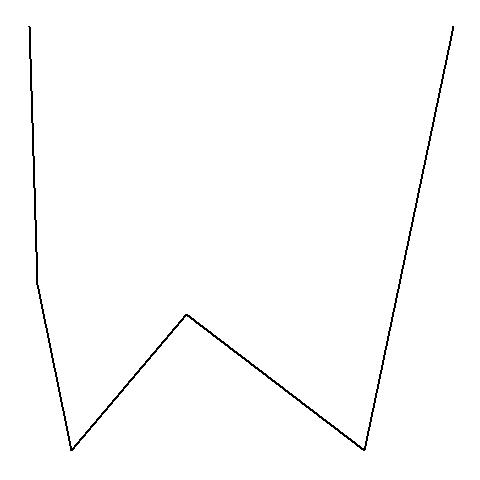

In [31]:
# Visualize single image

img = PILImage.create(uploader.data[0])
img

In [2]:
#Run for prediction on single image

is_dive,_,probs = learn.predict(img)
print(f"Which Dive Profile is this?: {is_dive}.")
print(f"Probability its correct: {probs[1].item():.6f}")